# 导入

## 导入包
这些是机器学习最常用的包, 值得系统学习:
* numpy: 矩阵运算, 向量化运算, Python科学计算的基础包
* pandas: 操作结构化数据.
* matplotlib: Python可视化的基础包
* seaborn: 绘制统计图
* scikit-learn: 机器学习库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 设置图形的风格
sns.set_style("darkgrid")
sns.set_palette("Set2")

# 显示DataFrame的所有内容
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## 定义函数

In [2]:
def plot_category(df, feature, group=None):
    """
    为了方便对所有特征进行比较, 建议对连续型特征进行离散化后, 也用这个绘图函数.
    对1个或者2个类别特征进行绘图
    返回两张子图:
    第一张是各个level的样本个数
    第二张是各个level下的生存率, 以及95%置信区间
    """
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    sns.countplot(x=feature, hue=group, data=df, ax=ax0)
    sns.barplot(x=feature, y="Survived", hue=group, data=df, ax=ax1)
    ax1.hlines(
        Survived_avg,
        -0.5,
        df[feature].nunique() - 0.5,
        colors="red",
        linestyles="dashed",
    )
    if not group:
        plt.suptitle(feature)
    else:
        plt.suptitle(feature + " | " + group)


## 导入数据

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df = pd.concat([df_train, df_test]).reset_index().drop(["index"], axis=1)
n_train = df_train.shape[0]
n_all = df.shape[0]
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 关于字段
* PassengerId: 整数编号, 对于没有什么用, 仍然保留它, 如果以后样本打乱顺序, 可以通过它来快速定位.
* Survived: 因变量, 训练集里面都是0或者1, 表示是否生存, 测试集里面都是NaN

##### 特征:
* Pclass: 表示阶层, 越小表示阶层越高, 从生存率高低或者Fare的平均值高低可以看出这一点.
* Sex: 性别, "女士孩子优先"原则让性别对生存率影响较大.
* Age: 年龄, "女士孩子优先"原则应该会让未成年人的生存率提高, 其他各个年龄段的生存率是否不同呢?
* Fare: 船票的总价(一张船票有可能让好几个乘客上船)
* Embarked: 上船地点.

##### 粗粗看起来没有什么用处, 但是, 如果考虑与其他乘客之间的关系的话, 对预测生死有可能有帮助的特征:
* Name: 姓名好像无法决定生死
* Ticket: 船票号码
* Cabin: 船舱号码
* SibSp: 兄弟姐妹或者配偶的个数
* Parch: 父母或者孩子的个数

## 关于因变量(Survived)

In [4]:
Survived_avg = np.around(df.Survived.mean(), decimals=2)
print(f"平均生存率: {Survived_avg}")

平均生存率: 0.38


* 发现生或死比例并不是太悬殊, 否则的话, 要重点考虑类别平衡的问题了.
* 这个平均生存率是比较重要的, 记住这个数字, 后面会多次用到

## 观察缺失值

In [5]:
df.isna().sum().sort_values(ascending=False).loc[lambda x: x > 0]

Cabin       1014
Survived     418
Age          263
Embarked       2
Fare           1
dtype: int64

* Survived缺失的都是测试集的部分
* Cabin, Age缺失比较严重, 如果一定要使用它们, 需要比较谨慎, 后来发现它们并不重要, 没有使用上.
* Embarked, Fare缺失较少

# EDA

## 新特征: Title

* "女士和孩子优先"原则下, 不需要特别分离出女孩了, 女孩和成年女性分为一类即可
* "女士和孩子优先"原则下, 男孩有必要从男性中分离出来, 男孩称为"boy", 成年男性称为"man"
* 为了和原先的特征"Sex"作区分, 称为"Title", 这两个特征的信息量是有比较大的重叠的, 可以考虑保留其中一个.

In [6]:
df["Title"] = "man"
df.loc[df.Sex == "female", "Title"] = "woman"
df.loc[df["Name"].str.contains("Master"), "Title"] = "boy"
df.Title.value_counts(normalize=True)

man      0.597403
woman    0.355997
boy      0.046600
Name: Title, dtype: float64

* man占了59.7%左右, woman占了35.6%左右, 男孩占了4.7%左右.
* 后面会发现这个占比很重要, man的占比很大, 但难以预测出幸存者, 这就是为什么最高分(83%左右)难以超出基准分(性别模型, 76.6%)太多的主要原因.

### 可视化

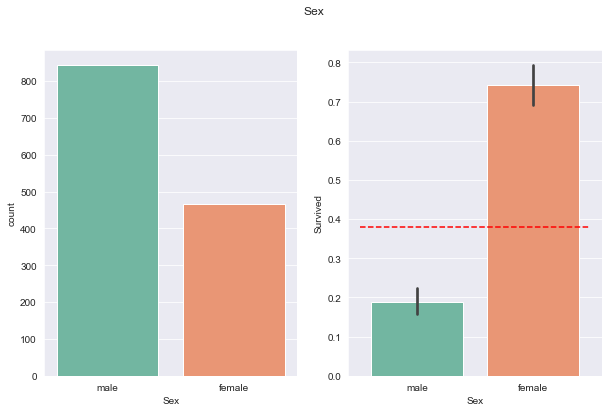

In [7]:
plot_category(df, "Sex")

* 发现male生存率远远低于平均值, female生存率远远高于平均值, 这就是为什么简单的**"gender model"**, 正确率就高达76.6%的原因.
* **"gender model"**: 预测完全只看Sex特征, 如果是male, 一律预测为死亡, 如果是female, 一律预测为生存.

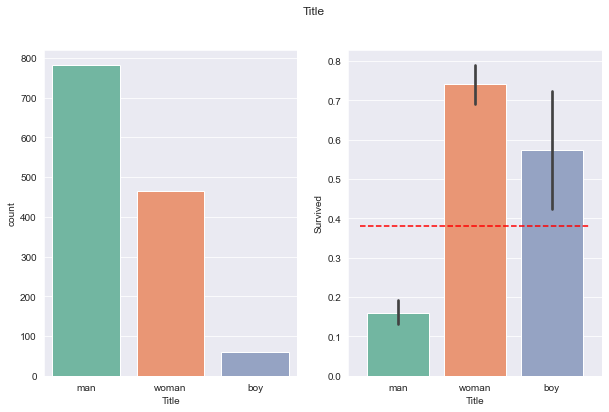

In [8]:
plot_category(df, "Title")

* 发现boy虽然也是男性, 但是生存率与man截然不同, man生存率不到20%, 而boy生存率接近60%
* 说明对男性分成细分成两类, 是有价值的
* 有遗憾的地方在于: boy的占比太小了, 对整体成绩的提升非常有限(理论上, 准确率最多提高4.7%左右)

### 为了保险起见, 验证一下: "不需要特别分离出女孩了, 女孩和成年女性分为一类即可"
* 假设14岁以及以下, 是女孩, 14岁以及以上, 是成年女性

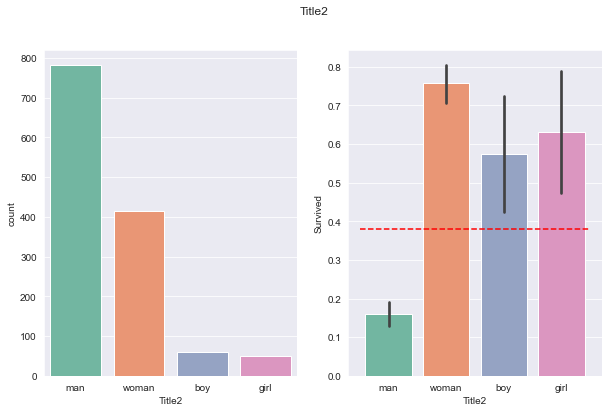

In [9]:
df["Title2"] = df["Title"]
df.loc[(df.Title == "woman") & (df.Age <= 14), "Title2"] = "girl"
plot_category(df, "Title2")
del df["Title2"]

* 发现woman与girl的生存率并没有显著差别, 因此, 不需要特别分离出女孩了, 女孩和成年女性分为一类即可

## 新特征: Pfare

* Fare: 船票的总价(一张船票有可能让好几个乘客上船)
* 因此, Fare是一个交叉性特征, 同时考虑了平均价格和一张票的乘客数量
* 对Fare这个特征进行"提纯", 求平均价格(Pfare), 平均价格更能体现出乘客的地位, 从而反映在生存率上.
* 有一些Fare取值为0, 这个设定不能接受, "没有免费的午餐", 将0赋值为NaN.

In [10]:
df.Fare.replace(0, np.NaN, inplace=True)
df["Pfare"] = df["Fare"] / df.groupby("Ticket")["Ticket"].transform("count")

### 可视化

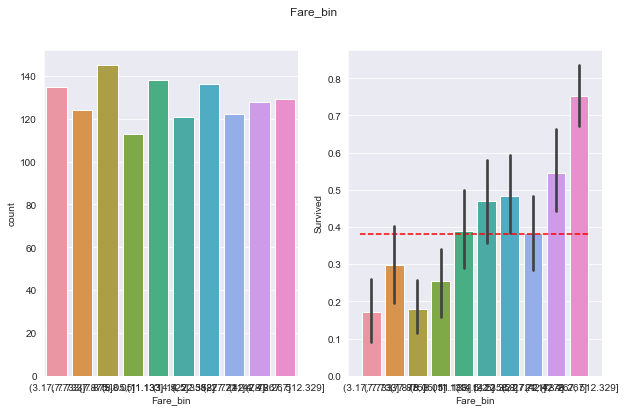

In [11]:
df["Fare_bin"] = pd.qcut(df["Fare"], 10)
plot_category(df, "Fare_bin")

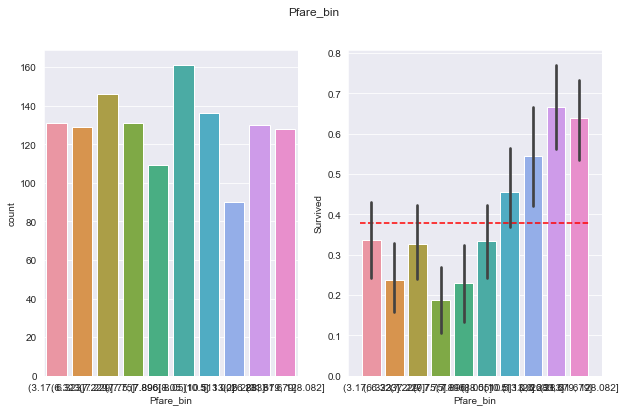

In [12]:
df["Pfare_bin"] = pd.qcut(df["Pfare"], 10)
plot_category(df, "Pfare_bin")

* 对比Fare与Pfare的图形, 发现Pfare的单调性更好.

## Pclass

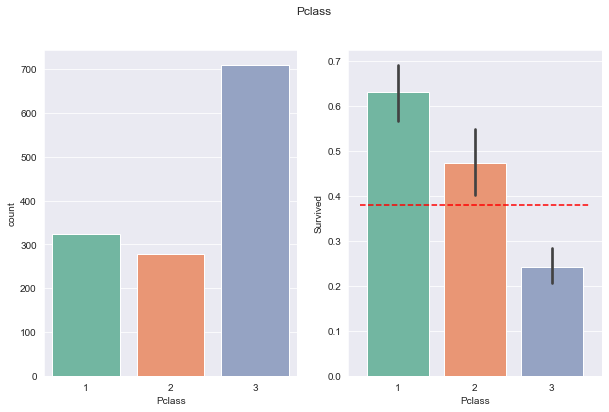

In [13]:
plot_category(df, "Pclass")

* 发现等级越高, 生存率越高, 符合预期

## Age

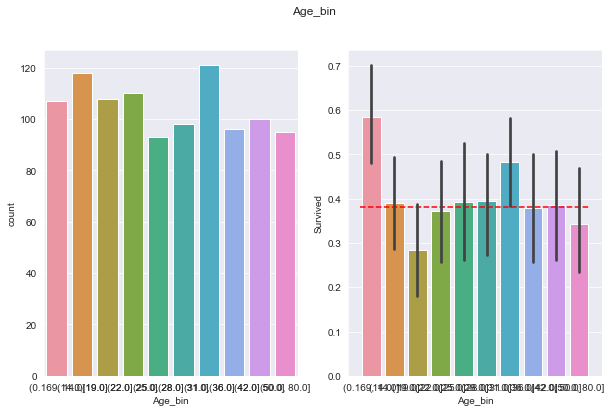

In [14]:
df["Age_bin"] = pd.qcut(df["Age"], 10)
plot_category(df, "Age_bin")

* 除了第一个区间(低年龄段), 其他区间的生存率都在平均生存率附近
* 但是低年龄段已经通过Title体现过了
* 因此, Age很可能是信息量低的特征, 可以考虑舍掉.

## SibSp

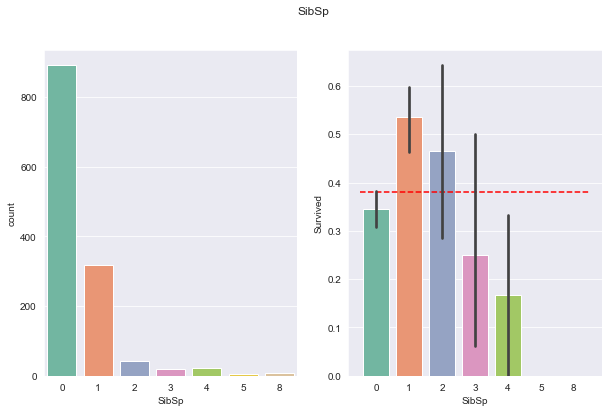

In [15]:
plot_category(df, "SibSp")

* 当为0时, 稍微低于平均值
* 当为1时, 稍微高于平均值
* 当为2时, 平均值附近
* 其他的取值因为样本少, 不做评价.
* 总体来看, 有弱预测性.

## Parch

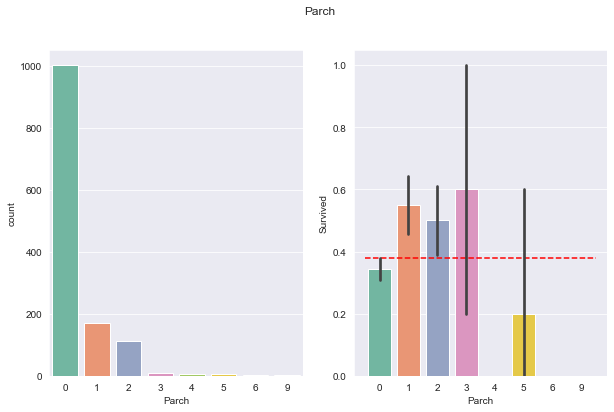

In [16]:
plot_category(df, "Parch")

* 当为0时, 稍微低于平均值
* 当为1时, 稍微高于平均值
* 当为2时, 稍微高于平均值
* 其他的取值因为样本少, 不做评价.
* 总体来看, 有弱预测性.

## Family

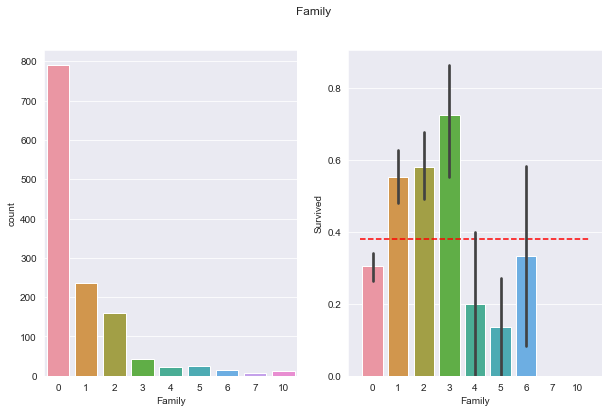

In [17]:
df["Family"] = df.SibSp + df.Parch
plot_category(df, "Family")

* 当为0时, 稍微低于平均值
* 当为1或2或3时, 稍微高于平均值
* 其他的取值因为样本少, 不做评价.
* 总体来看, 有弱预测性, 但是比SibSp, Parch都要强.

## Embarked

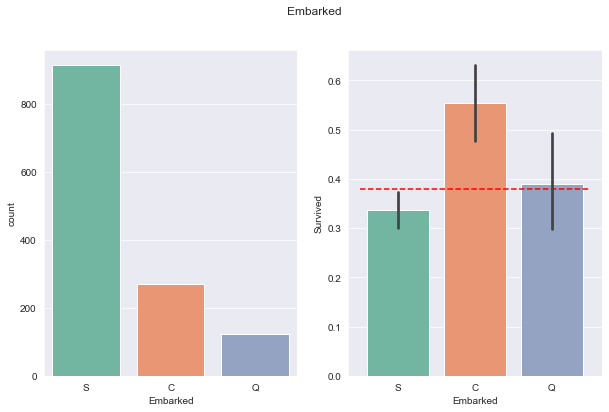

In [18]:
plot_category(df, "Embarked")

* 取值为C时, 高于平均值
* 取值为S时, 低于平均值
* 取值为Q时, 在平均值附近
* 总体来看, 是中等预测能力的特征.

## 单个特征的预测能力排名:
#### 基于图形主观判断

#### 强预测能力特征:
* Title, Sex
* Pclass
* Pfare

#### 中预测能力特征:
* Embarked

#### 弱预测能力特征:
* Family, Parch, SibSp

#### 无预测能力特征:
* Age


下文中, 不再去考虑Family, Parch, SibSp, 因为这些都是家庭因素, WCG模型也是考虑家庭因素, 而且巧妙得多.

也不会考虑Age.

Title是目前最强的特征, 而且后面的WCG模型和"Voting of KNN"模型也是根据Title进行分治的.

因此, 后面的交叉特征必须要有Title, 没有Title的交叉特征不考虑.

### 删除以后用不到的特征, 主要目的是简化数据显示, 重点关注重要的特征.

In [19]:
df.drop(["Sex", "Cabin", "Family", "Parch", "SibSp", "Age", "Age_bin", "Fare_bin"], axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Ticket,Fare,Embarked,Title,Pfare,Pfare_bin
0,1,0.0,3,"Braund, Mr. Owen Harris",A/5 21171,7.2500,S,man,7.25000,"(7.229, 7.75]"
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C,woman,35.64165,"(31.679, 128.082]"
2,3,1.0,3,"Heikkinen, Miss. Laina",STON/O2. 3101282,7.9250,S,woman,7.92500,"(7.896, 8.05]"
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,S,woman,26.55000,"(26.283, 31.679]"
4,5,0.0,3,"Allen, Mr. William Henry",373450,8.0500,S,man,8.05000,"(7.896, 8.05]"


## Title与Pclass交叉

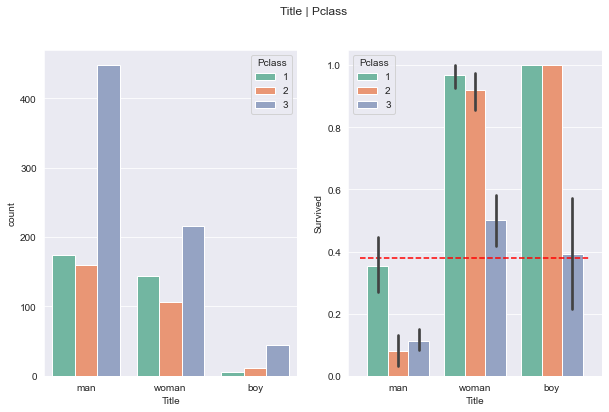

In [20]:
plot_category(df, "Title", group="Pclass")

* man不管是什么Pclass, 都无法达到平均生存率, Pclass == 1的man稍低于平均生存率
* woman不管是什么Pclass, 都超过了平均生存率, Pclass == 3的woman稍高于平均生存率
* boy不管是什么Pclass, 都超过了平均生存率, Pclass == 3的boy接近于平均生存率

## Title与Pfare交叉

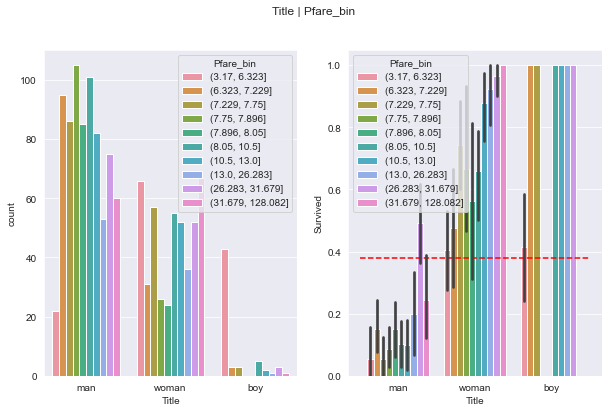

In [21]:
plot_category(df, "Title", group="Pfare_bin")

* 对于man, 第2高档的Pfare的生存率接近于平均值.
* 对于woman或boy, 最低档的Pfare的生存率在平均值附近.

## Title与Embarked交叉

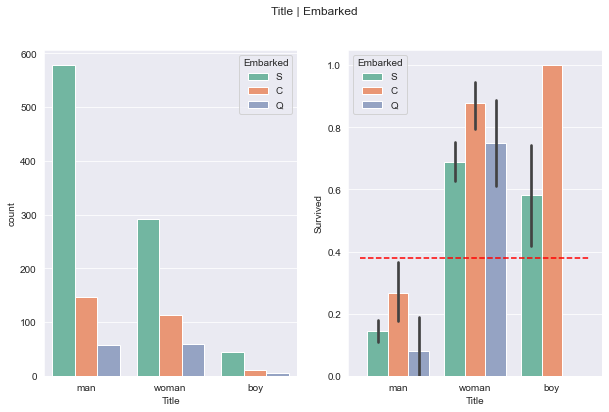

In [22]:
plot_category(df, "Title", group="Embarked")

* Embarked == Q的boy, 生存率为0%, 可能是有偶然性的, 因为这样的样本太少.
* 其他的group形状符合预期.

In [23]:
df.loc[(df.Title == "boy") & (df.Embarked == "Q")]

,PassengerId,Survived,Pclass,Name,Ticket,Fare,Embarked,Title,Pfare,Pfare_bin
16,17,0.0,3,"Rice, Master. Eugene",382652,29.125,Q,boy,4.854167,"(3.17, 6.323]"
171,172,0.0,3,"Rice, Master. Arthur",382652,29.125,Q,boy,4.854167,"(3.17, 6.323]"
278,279,0.0,3,"Rice, Master. Eric",382652,29.125,Q,boy,4.854167,"(3.17, 6.323]"
787,788,0.0,3,"Rice, Master. George Hugh",382652,29.125,Q,boy,4.854167,"(3.17, 6.323]"
946,947,NaN,3,"Rice, Master. Albert",382652,29.125,Q,boy,4.854167,"(3.17, 6.323]"


* 发现Embarked == Q的boy应该是在自于同一个家庭(成为"Rice"家庭), 同一个家庭出现同生同死的概率相当大(下文中会验证这一点), 不巧的是, 这个家庭正好落在了"同死"这个状态.

## Title, Pclass, Pfare交叉

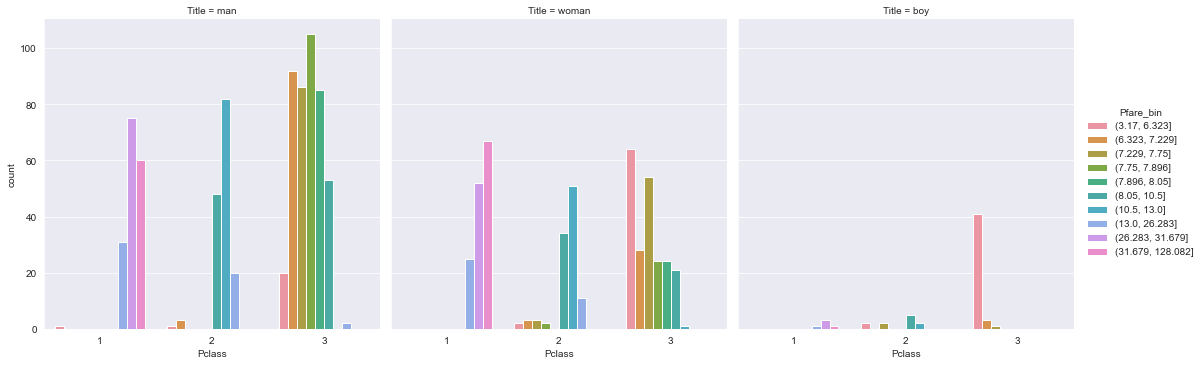

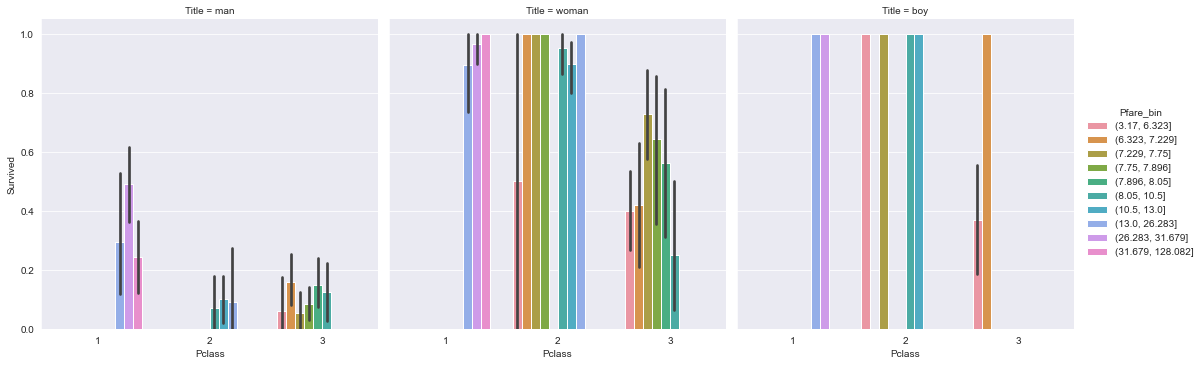

In [24]:
sns.catplot(x="Pclass", y=None, hue="Pfare_bin", col="Title", data=df, kind="count")
sns.catplot(x="Pclass", y="Survived", hue="Pfare_bin", col="Title", data=df, kind="bar")

* 对于man, Pclass == 1, 第2高档的Pfare, 生存率接近平均值
* 对于woman或者boy, Pclass == 3, 最低档的Pfare, 生存率接近平均值

## Title, Pclass, Embarked交叉

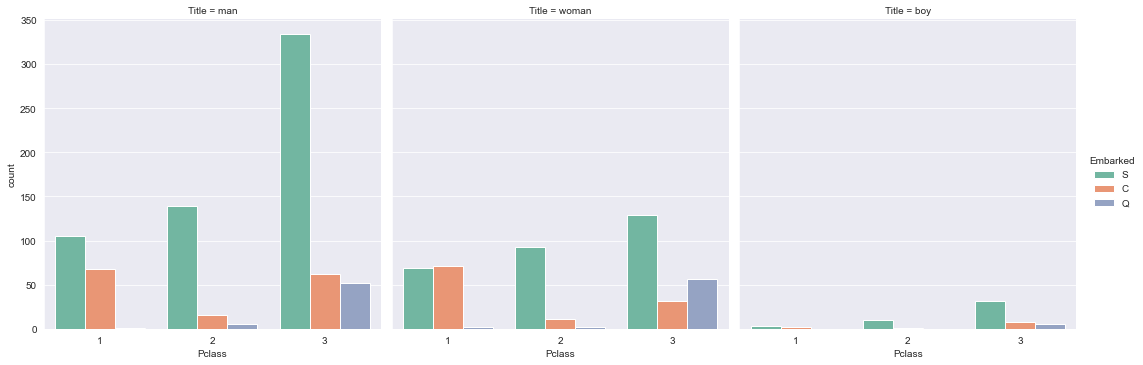

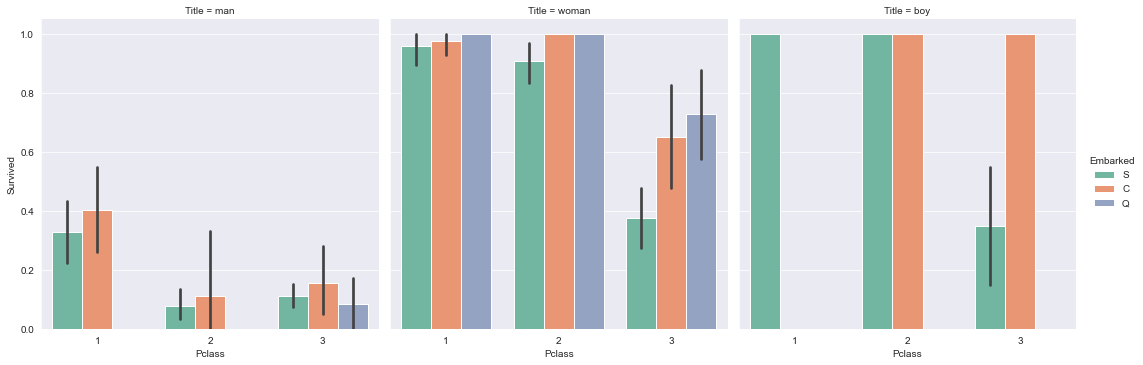

In [25]:
sns.catplot(x="Pclass", y=None, hue="Embarked", col="Title", data=df, kind="count")
sns.catplot(x="Pclass", y="Survived", hue="Embarked", col="Title", data=df, kind="bar")

* 对于man, Pclass == 1, 生存率接近平均值
* 对于woman或者boy, Pclass == 3, Embarked == S, 生存率接近平均值

## Title, Pfare, Embarked交叉

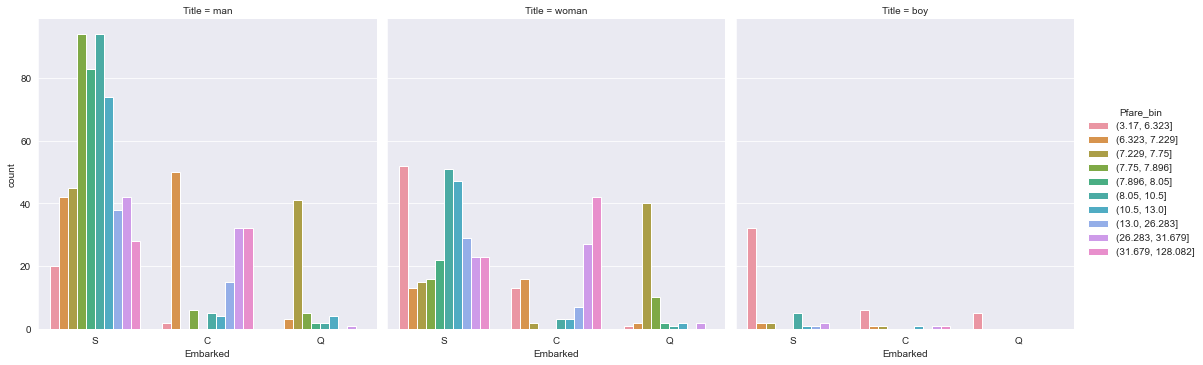

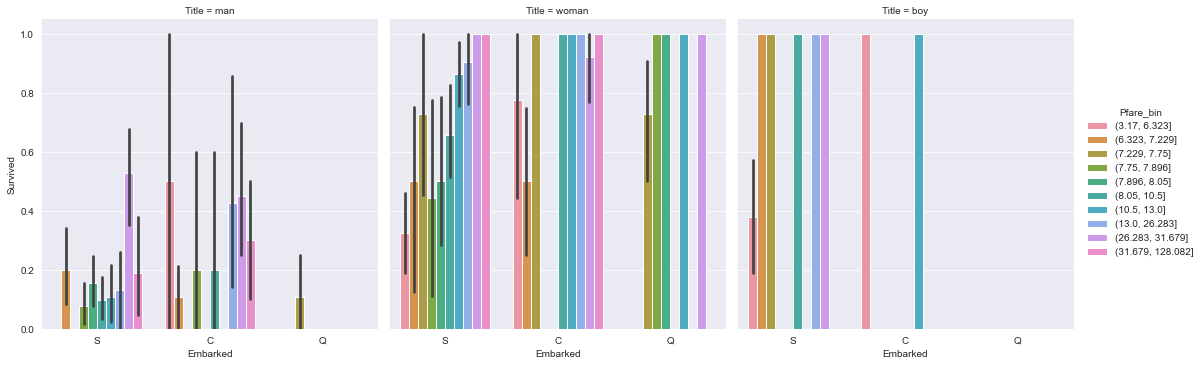

In [26]:
sns.catplot(x="Embarked", y=None, hue="Pfare_bin", col="Title", data=df, kind="count")
sns.catplot(x="Embarked", y="Survived", hue="Pfare_bin", col="Title", data=df, kind="bar")

* 对于man, 在Embarked == S, 第2高Pfare档位, 生存率接近于平均值
* 对于woman, 在Embarked == S, 最低Pfare档位, 生存率接近于平均值
* 对于boy, 在Embarked == S, 最低Pfare档位, 生存率接近于平均值

## Title, Pclass, Pfare, Embarked交叉

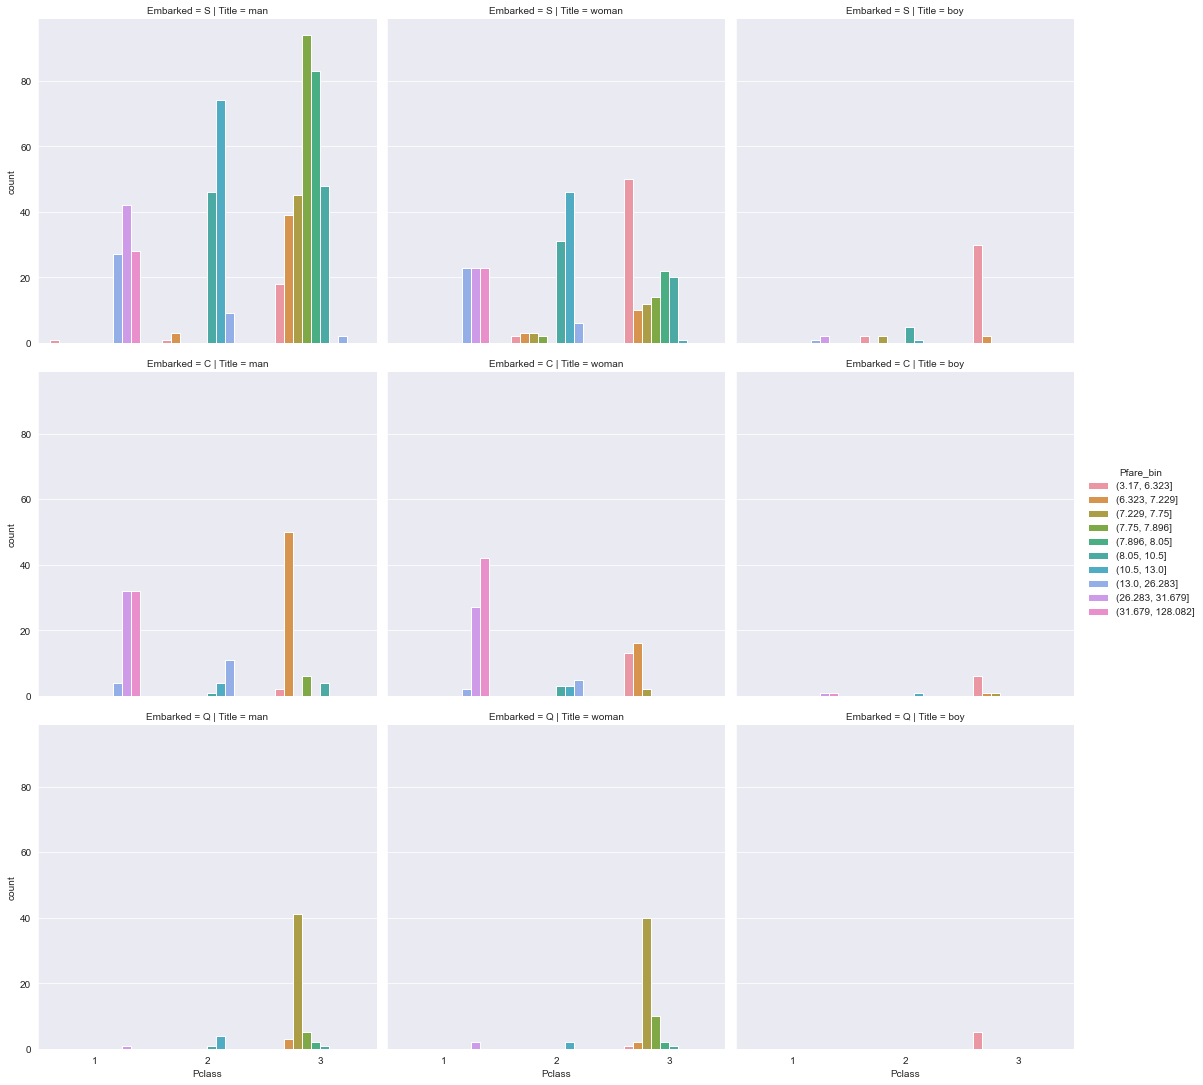

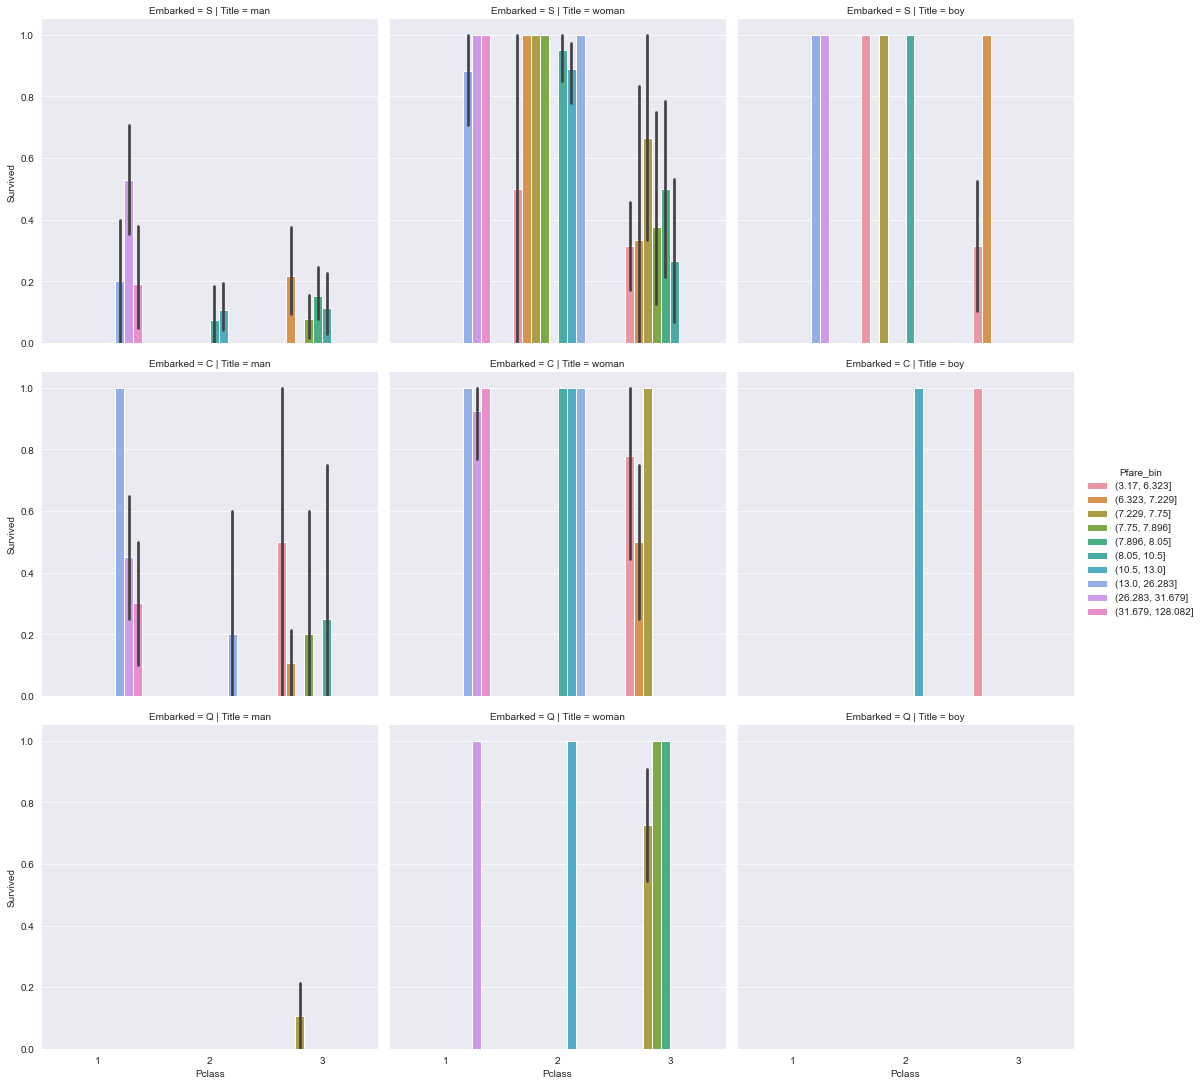

In [27]:
sns.catplot(x="Pclass", y=None, hue="Pfare_bin", row="Embarked", col="Title", data=df, kind="count")
sns.catplot(x="Pclass", y="Survived", hue="Pfare_bin", row="Embarked", col="Title", data=df, kind="bar")

* 对于man, Pclass == 1, Embarked == "S", Pfare第2高档位上, 生存率高于平均值
* 对于woman, Pclass == 3, Embarked == "S", Pfare最低档位上, 生存率接近于平均值
* 对于boy, Pclass == 3, Embarked == "S", Pfare最低档位上, 生存率接近于平均值

## 小结
* 对于单个特征进行了排名, 对特征的预测能力有个总体的判断
* 使用二重交叉特征, 三重交叉特征, 四重交叉特征, 对于发现那些异常情况非常有帮助.
* 发现二重交叉特征, 三重交叉特征的异常情况是和四重交叉特征的异常情况不矛盾的, 是一致的.
* 因此, 只保留下四重交叉特征的异常情况:
* 对于man, Pclass == 1, Embarked == "S", Pfare第2高档位上, 生存率高于平均值
* 对于woman, Pclass == 3, Embarked == "S", Pfare最低档位上, 生存率接近于平均值
* 对于boy, Pclass == 3, Embarked == "S", Pfare最低档位上, 生存率接近于平均值
* 还有一些小样本的情况.

In [28]:
df.loc[(df.Title == "man") 
       & (df.Pclass == 1)
       & (df.Embarked.isin(["S"])) 
       & (26.832 < df.Pfare) 
       & (df.Pfare <= 31.679),
       "Survived"].mean()

0.5833333333333334

In [29]:
df.loc[(df.Title == "woman") 
       & (df.Pclass == 3)
       & (df.Embarked.isin(["S"]))
       & (df.Pfare <= 6.323),
       "Survived"].mean()

0.3142857142857143

In [30]:
df.loc[(df.Title == "boy") 
       & (df.Pclass == 3)
       & (df.Embarked.isin(["S"])) 
       & (df.Pfare <= 6.323),
       "Survived"].mean()

0.3157894736842105

* 验证了上面说的三种异常情况.
* 对于man的异常情况, 生存率是58%, 虽然高于平均生存率(38%), 但是只比50%高一点点.
* 对于woman或者boy的异常情况, 生存率分为了31.4%, 31.6%, 如果预测他们为死亡, 看起来不错.
* 但是, 并不打算选择直接使用交叉特征做预测, 原因:
1. 3种异常情况的样本并不太多, 而且准确率也不算高, 因此, 总体准确率不会提高太多.
2. 有过拟的风险, 准确率要进一步下调.
3. 想法比较naive, 没有用到任何机器学习模型.
4. 并不好评估泛化能力.

* 虽然不能做出预测, 但是, 对各个特征以及它们之间的交叉情况有了非常直观的了解, 为以后的建模, 打下了基础, 比如:
1. Title是目前发现的最重要特征, 下文中, 对样本的分治以Title为主.
2. Pclass是目前发现第二重要的特征.
3. Pfare是目前发现第三重要的特征.
4. Embarked是目前发现第四重要的特征, 发现的三种异常情况都是在"S"上. 当然, 还有一些小样本情况.

# 使用WCG模型对WCG乘客进行预测

* WCG模型是本文中最核心, 最精彩的部分
* WCG模型不是我的想到的, 当然, 并不是因为我太菜了, 而是对于任何一个人来说, 都是难以想到的.
* WCG模型难以想到的原因:
1. Name一般会被想当然的认为类似Id的东西, 很有可能直接删除掉了, 不会想到去分析它.
2. 家庭成员个数通常是3个以内, 不超过11个, 统计家庭生存率一般会被认为是过拟的.
3. 统计家庭存活率的时候, 将man剔除出去, 这个比较难想到的.
4. 考虑到可能存在女保姆这类群体.
* 每一条都至少淘汰90%的人, 单个人同时考虑到以上4条的, 概率是万中无一.
* 还好Kaggle可以分享的, 不断有人在其他人工作的基础上做出更多的努力, 逐渐凑齐了这4条, WCG模型属于Kaggle社区的**集体智慧**

* 暂时看不懂上面描述的, 没关系, 下文会具体描述.

## WCG模型的核心概念: Woman-Child-Groups (WCG)
* 注意, WCG不同于WCG模型, WCG是一种分组方法, WCG模型是基于WCG的预测模型.
* WCG用一句话来概括, 就是: 将一个家庭内的所有女性(包括女保姆)或孩子认定为一组.
* 需要特别留意的是: 一个家庭内的成年男性并没有分到组里面.
* 这背后的逻辑是: 
1. 一个家庭内的成员活动在一起, 同生或同死的概率极大, 可以利用这个性质, 如果一个组内的成员一部分在训练集里面, 一部分在测试集里面, 根据训练集的生存率就可以去预测测试集成员的生死.
2. 男人因为"女士和孩子优先"这条规则, 并不遵循第1条逻辑.
3. 虽然传统意义上, 女保姆不算是家庭成员, 但是女保姆和东家活动在一起, 也符合"女士和孩子优先"这条规则的, 因此, 女保姆的生存率和东家的女生孩子的生存率应该是没有任何区别的.

### WCG组号(GroupId)的计算方法: **GroupId = Surname + Pclass + Ticket(舍掉最后一位) + Fare + Embarked**
* 一家人就应该有相同的Surname, 和中国不同, 很多国家女性嫁人以后, 就随丈夫的姓氏.
* 一家人应该是相同的阶层.
* 一家人应该是使用相同的船票.
* 其中Ticket舍掉最后一位, 因为发现有些实际上是一家人, 但是Ticket最后一位不同(这种情况并不多见, 发现这种现象的人观察力惊人!)
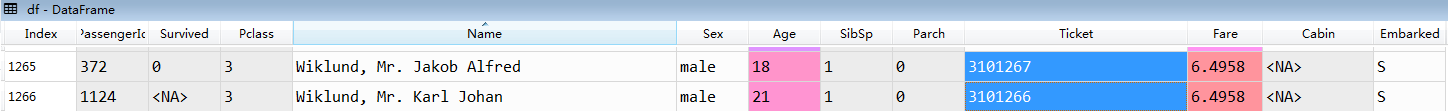

* 因为舍掉了最后一位, 有可能两张不同Ticket被认为是相同的Ticket了, 因此, 需要Fare, Embarked来进一步确认.
* 这个公式里面, 没用Cabin, 有两个理由:
1. Cabin与Ticket信息是有冗余的.
2. Cabin的缺失率太高了.
3. 如果家庭成员的人数较多, 有可能分在了不同Cabin里面.


* 关于GroupId的后续处理(修正方法):
1. 将所有的man的GroupId赋值为"noGroup", 因为前面提到了, man并不属于任何WCG.
2. 将组内成员个数为1的乘客的GroupId, 赋值为"noGroup", 逻辑很简单, 单独一个人, 不能算是一个"Group", 
   另外, 对于预测毫无用处, 单独一个人无法用来预测其他乘客的生死.
3. 将女保姆的GroupId改为东家的GroupId, 关于女保姆的认定方法会在下文中细讲.

In [31]:
df["Surname"] = df["Name"].str.split(",").str[0]

df["Ticket_id"] = (
    df.Pclass.astype(str)
    + "-"
    + df.Ticket.str[:-1].astype(str)
    + "-"
    + df.Fare.astype(str)
    + "-"
    + df.Embarked.astype(str)
)

df["Group_id"] = df.Surname + "-" + df["Ticket_id"]

# 后续处理
df.loc[df.Title == "man", "Group_id"] = "noGroup"
df["WC_count"] = (
    df.loc[df.Title != "man"]
    .groupby("Group_id")["Group_id"]
    .transform("count")
)
df.loc[df.WC_count <= 1, "Group_id"] = "noGroup"

### 女保姆的认定
* 注意: 女保姆只是对一类人的称呼, 并不能保证一定是这样的职业, 是不是这样的职业, 不影响预测.

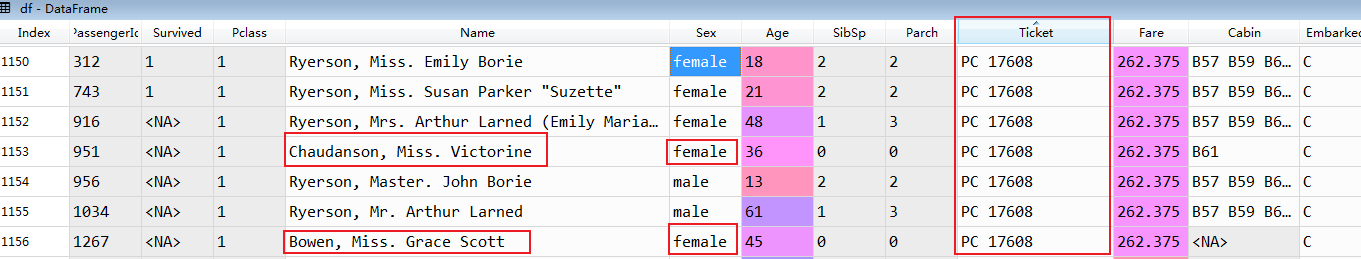

* 红框圈出来的两个人, 发现除了Surname不符合GroupId的标准, 其他都符合.

* 定义一个新的组号(不是WCG的组号, 仅仅用来辅助认定女保姆的): **TicketId = Pclass + Ticket(舍掉最后一位) + Fare + Embarked**

* 女保姆的认定标准:
1. 不能是man, 因为WCG以及排除掉man了, 理论上有可能是boy, 实际发现找出来的都是woman, 这是将这类人命名为"女保姆"的原因之一.
2. GroupId为"noGroup", 即, 假设女保姆是单独一人(女保姆在船上没有家人)和东家在一起.
3. 存在与该样本TicketId相同的WCG(东家的GroupId不能为"noGroup")

* 认定为女保姆以后, 将该样本的GroupId(原先为"noGroup")修正为东家的GroupId, 即女保姆算是东家的成员.


**思考**: 
* 前面对GroupId的后续处理中, 将组内成员个数为1的乘客的GroupId, 赋值为"noGroup"(下文中简称为"规则2"), 
* 基于女保姆的认定标准3, 意味着如果东家是一个人的话, 女保姆不会被认定为女保姆.
* 那么, 规则2是不是有合理性呢?
* 答案是有合理性.
* 因为规则2虽然会造成"如果东家是一个人的话, 女保姆不会被认定为女保姆", 
* 但是更多的避免了"两个乘客恰好只是同票, 实际上没有任何关系, 既不是同一个家庭, 也不是东家与女保姆的关系".
* 规则2要求家庭成员至少是2个, 那么那个"异姓"的是女保姆的概率就非常大了, 如果家庭成员只有1个, 那个"异姓"的是女保姆的概率比较小.

In [32]:
indices = []
count = 0
for i in range(n_all):
    if df.loc[i, "Title"] != "man" and df.loc[i, "Group_id"] == "noGroup":
        idx = np.flatnonzero(
            (df["Ticket_id"] == df.loc[i, "Ticket_id"])
            & (df["Group_id"] != "noGroup")
        )
        if len(idx):
            df.loc[i, "Group_id"] = df.loc[idx[0], "Group_id"]
            indices.append(i)
            count += 1
print(f"发现了{count}个女保姆")
df.loc[indices]

发现了11个女保姆


,PassengerId,Survived,Pclass,Name,Ticket,Fare,Embarked,Title,Pfare,Pfare_bin,Surname,Ticket_id,Group_id,WC_count
337,338,1.0,1,"Burns, Miss. Elizabeth Margaret",16966,134.5000,C,woman,26.900000,"(26.283, 31.679]",Burns,1-1696-134.5-C,Spedden-1-1696-134.5-C,1.0
708,709,1.0,1,"Cleaver, Miss. Alice",113781,151.5500,S,woman,25.258333,"(13.0, 26.283]",Cleaver,1-11378-151.55-S,Allison-1-11378-151.55-S,1.0
950,951,NaN,1,"Chaudanson, Miss. Victorine",PC 17608,262.3750,C,woman,37.482143,"(31.679, 128.082]",Chaudanson,1-PC 1760-262.375-C,Ryerson-1-PC 1760-262.375-C,1.0
1032,1033,NaN,1,"Daniels, Miss. Sarah",113781,151.5500,S,woman,25.258333,"(13.0, 26.283]",Daniels,1-11378-151.55-S,Allison-1-11378-151.55-S,1.0
1067,1068,NaN,2,"Sincock, Miss. Maude",C.A. 33112,36.7500,S,woman,9.187500,"(8.05, 10.5]",Sincock,2-C.A. 3311-36.75-S,Davies-2-C.A. 3311-36.75-S,1.0
1140,1141,NaN,3,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",2660,14.4542,C,woman,7.227100,"(6.323, 7.229]",Khalil,3-266-14.4542-C,Zabour-3-266-14.4542-C,1.0
1171,1172,NaN,3,"Oreskovic, Miss. Jelka",315085,8.6625,S,woman,8.662500,"(8.05, 10.5]",Oreskovic,3-31508-8.6625-S,Cacic-3-31508-8.6625-S,1.0
1258,1259,NaN,3,"Riihivouri, Miss. Susanna Juhantytar Sanni""""",3101295,39.6875,S,woman,5.669643,"(3.17, 6.323]",Riihivouri,3-310129-39.6875-S,Panula-3-310129-39.6875-S,1.0
1262,1263,NaN,1,"Wilson, Miss. Helen Alice",16966,134.5000,C,woman,26.900000,"(26.283, 31.679]",Wilson,1-1696-134.5-C,Spedden-1-1696-134.5-C,1.0
1266,1267,NaN,1,"Bowen, Miss. Grace Scott",PC 17608,262.3750,C,woman,37.482143,"(31.679, 128.082]",Bowen,1-PC 1760-262.375-C,Ryerson-1-PC 1760-262.375-C,1.0


* 发现这11个女保姆里面, 有9个是测试集里面的, 最多可以提高成绩9/418=2.15%, 说明发现女保姆的努力是有价值的.
* 下文可以发现, 其中3个女保姆被预测死亡, 分别是索引号为1140, 1171, 1258, 她们的Pclass都为3, 其他都被预测为生存, 她们的Pclass都为1或2.

## 非WCG乘客("noGroup")与WCG乘客(非"noGroup")的区别
* 下文中会根据Group_id是否为"noGroup", 对样本进行分治, WCG乘客会用WCG模型进行预测, 非WCG乘客会用其他模型进行预测
* 在此之前, 有必要说明一下, 这种分治是有必要的.

### Title分布比较

In [33]:
print(f"非WCG组号个数: {df.Group_id.loc[lambda x: x == 'noGroup'].nunique()}")
print(f"WCG组号个数: {df.Group_id.loc[lambda x: x != 'noGroup'].nunique()}")

print()
print(f"非WCG乘客个数: {df.Group_id.loc[lambda x: x == 'noGroup'].count()}")

print()
print(f"WCG乘客个数: {df.Group_id.loc[lambda x: x != 'noGroup'].count()}")

print()
print("非WCG乘客的Title分布:")
print(df.loc[df.Group_id == "noGroup", "Title"].value_counts())

print()
print("WCG乘客的Title分布:")
print(df.loc[df.Group_id != "noGroup", "Title"].value_counts())

print()
print("全体乘客的Title分布:")
print(df.Title.value_counts())

print()
print("非WCG覆盖率:")
print((df.loc[df.Group_id == "noGroup", "Title"].value_counts() / df.Title.value_counts()).fillna(0.0))

print()
print("WCG覆盖率:")
print((df.loc[df.Group_id != "noGroup", "Title"].value_counts() / df.Title.value_counts()).fillna(0.0))

非WCG组号个数: 1
WCG组号个数: 80

非WCG乘客个数: 1079

WCG乘客个数: 230

非WCG乘客的Title分布:
man      782
woman    295
boy        2
Name: Title, dtype: int64

WCG乘客的Title分布:
woman    171
boy       59
Name: Title, dtype: int64

全体乘客的Title分布:
man      782
woman    466
boy       61
Name: Title, dtype: int64

非WCG覆盖率:
man      1.000000
woman    0.633047
boy      0.032787
Name: Title, dtype: float64

WCG覆盖率:
boy      0.967213
man      0.000000
woman    0.366953
Name: Title, dtype: float64


* 只有占比230/1309的乘客是WCG乘客, 另外占比1079/1309的乘客需要其他模型来进行预测.
* 大约有96.7%的boy是WCG成员.
* 大约有36.7%的woman是WCG成员.
* 没有man是WCG成员.

### 生存率的区别

#### 对于man, 全部是非WCG乘客, 生存率:

In [34]:
df.loc[(df.Title == "man") & (df.Group_id == "noGroup"), "Survived"].mean()

0.1601489757914339

#### 对于boy, 大部分是WCG乘客, 只有2个是非WCG乘客, 而且恰好都在测试集里面, 无法计算生存率, 不过根据特征分析, 生存率应该是0%.

In [35]:
df.loc[(df.Title == "boy") & (df.Group_id == "noGroup"), "Survived"].mean()

nan

In [36]:
df.loc[(df.Title == "boy") & (df.Group_id == "noGroup")]

,PassengerId,Survived,Pclass,Name,Ticket,Fare,Embarked,Title,Pfare,Pfare_bin,Surname,Ticket_id,Group_id,WC_count
912,913,NaN,3,"Olsen, Master. Artur Karl",C 17368,3.1708,S,boy,3.1708,"(3.17, 6.323]",Olsen,3-C 1736-3.1708-S,noGroup,1.0
1230,1231,NaN,3,"Betros, Master. Seman",2622,7.2292,C,boy,7.2292,"(6.323, 7.229]",Betros,3-262-7.2292-C,noGroup,1.0


* 只有两个样本, 根据之前的四重交叉特征分析, 全部都死亡的概率比较大.

#### 对于woman, 非WCG乘客和WCG乘客占比都不小, 因此, 两边的生存率计算有了意义:

In [37]:
df.loc[(df.Title == "boy") & (df.Group_id != "noGroup"), "Survived"].mean()

0.575

In [38]:
df.loc[(df.Title == "woman") & (df.Group_id == "noGroup"), "Survived"].mean()

0.8181818181818182

In [39]:
df.loc[(df.Title == "woman") & (df.Group_id != "noGroup"), "Survived"].mean()

0.6120689655172413

* 令人吃惊的是: 单身woman比非单身woman的生存率高出了将近20%, 是因为单身woman行动更灵活方便?

### 小结
* 非WCG乘客与WCG乘客的分布是相差比较大的.
* 非WCG乘客与WCG乘客的各个Title生存率也是相差比较大的.
* 因此, 这种分治, 是有必要的.

## 组内生存率
* 发现一个家庭内的成员同生或同死的概率极大, 可以利用这个性质, 如果一个组内的成员一部分在训练集里面, 一部分在测试集里面, 根据训练集的生存率就可以去预测测试集成员的生死.

In [40]:
df["WCSurvived"] = df.loc[df.Group_id != "noGroup"].groupby("Group_id").Survived.transform("mean")

### 组内生存率的分布

In [41]:
print("组内生存率的分布:")
print(df.WCSurvived.value_counts())

组内生存率的分布:
1.00    134
0.00     76
0.75      6
0.50      5
Name: WCSurvived, dtype: int64


* 发现组内生存率大部分是0.0或者1.0, 即同生同死的概率非常大, 组内生存率的预测能力比以往发现的任何特征都更强!

In [42]:
df.loc[df.WCSurvived == 0.75]

,PassengerId,Survived,Pclass,Name,Ticket,Fare,Embarked,Title,Pfare,Pfare_bin,Surname,Ticket_id,Group_id,WC_count,WCSurvived
25,26,1.0,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",347077,31.3875,S,woman,4.483929,"(3.17, 6.323]",Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
182,183,0.0,3,"Asplund, Master. Clarence Gustaf Hugo",347077,31.3875,S,boy,4.483929,"(3.17, 6.323]",Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
233,234,1.0,3,"Asplund, Miss. Lillian Gertrud",347077,31.3875,S,woman,4.483929,"(3.17, 6.323]",Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
261,262,1.0,3,"Asplund, Master. Edvin Rojj Felix",347077,31.3875,S,boy,4.483929,"(3.17, 6.323]",Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
1045,1046,NaN,3,"Asplund, Master. Filip Oscar",347077,31.3875,S,boy,4.483929,"(3.17, 6.323]",Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
1270,1271,NaN,3,"Asplund, Master. Carl Edgar",347077,31.3875,S,boy,4.483929,"(3.17, 6.323]",Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75


* 组内生存率为0.75, 但是:
* Pclass == 3, Pfare处在最低档, Embarked == "S", 这种情况属于之前发现的boy大概率死亡的情况.

In [43]:
df.loc[df.WCSurvived == 0.5]

,PassengerId,Survived,Pclass,Name,Ticket,Fare,Embarked,Title,Pfare,Pfare_bin,Surname,Ticket_id,Group_id,WC_count,WCSurvived
297,298,0.0,1,"Allison, Miss. Helen Loraine",113781,151.55,S,woman,25.258333,"(13.0, 26.283]",Allison,1-11378-151.55-S,Allison-1-11378-151.55-S,3.0,0.5
305,306,1.0,1,"Allison, Master. Hudson Trevor",113781,151.55,S,boy,25.258333,"(13.0, 26.283]",Allison,1-11378-151.55-S,Allison-1-11378-151.55-S,3.0,0.5
498,499,0.0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",113781,151.55,S,woman,25.258333,"(13.0, 26.283]",Allison,1-11378-151.55-S,Allison-1-11378-151.55-S,3.0,0.5
708,709,1.0,1,"Cleaver, Miss. Alice",113781,151.55,S,woman,25.258333,"(13.0, 26.283]",Cleaver,1-11378-151.55-S,Allison-1-11378-151.55-S,1.0,0.5
1032,1033,NaN,1,"Daniels, Miss. Sarah",113781,151.55,S,woman,25.258333,"(13.0, 26.283]",Daniels,1-11378-151.55-S,Allison-1-11378-151.55-S,1.0,0.5


* 组内生存率为0.5, 但是:
* Pclass == 1, Pfare处在较高档, 这种情况属于之前发现的woman大概率生存的情况.

### 找出哪些组是全部成员都在测试集里面的:

* 前面提到了"如果一个组内的成员一部分在训练集里面, 一部分在测试集里面, 根据训练集的生存率就可以去预测测试集成员的生死"
* 但是, 如果一个组内的全部成员都在测试集里面, 又该如何?

In [44]:
groups_test = set(df[n_train:].Group_id.unique()) - set(df[:n_train].Group_id.unique())
df.loc[df.Group_id.isin(groups_test)].sort_values(by="Surname")

,PassengerId,Survived,Pclass,Name,Ticket,Fare,Embarked,Title,Pfare,Pfare_bin,Surname,Ticket_id,Group_id,WC_count,WCSurvived
1259,1260,NaN,1,"Gibson, Mrs. Leonard (Pauline C Boeson)",112378,59.4000,C,woman,29.700000,"(26.283, 31.679]",Gibson,1-11237-59.4-C,Gibson-1-11237-59.4-C,2.0,NaN
1293,1294,NaN,1,"Gibson, Miss. Dorothy Winifred",112378,59.4000,C,woman,29.700000,"(26.283, 31.679]",Gibson,1-11237-59.4-C,Gibson-1-11237-59.4-C,2.0,NaN
1044,1045,NaN,3,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",350405,12.1833,S,woman,6.091650,"(3.17, 6.323]",Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,NaN
1154,1155,NaN,3,"Klasen, Miss. Gertrud Emilia",350405,12.1833,S,woman,6.091650,"(3.17, 6.323]",Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,NaN
1050,1051,NaN,3,"Peacock, Mrs. Benjamin (Edith Nile)",SOTON/O.Q. 3101315,13.7750,S,woman,4.591667,"(3.17, 6.323]",Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,NaN
1172,1173,NaN,3,"Peacock, Master. Alfred Edward",SOTON/O.Q. 3101315,13.7750,S,boy,4.591667,"(3.17, 6.323]",Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,NaN
1300,1301,NaN,3,"Peacock, Miss. Treasteall",SOTON/O.Q. 3101315,13.7750,S,woman,4.591667,"(3.17, 6.323]",Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,NaN
1083,1084,NaN,3,"van Billiard, Master. Walter John",A/5. 851,14.5000,S,boy,4.833333,"(3.17, 6.323]",van Billiard,3-A/5. 85-14.5-S,van Billiard-3-A/5. 85-14.5-S,2.0,NaN
1235,1236,NaN,3,"van Billiard, Master. James William",A/5. 851,14.5000,S,boy,4.833333,"(3.17, 6.323]",van Billiard,3-A/5. 85-14.5-S,van Billiard-3-A/5. 85-14.5-S,2.0,NaN


* 全部成员都在测试集里的家族有: Gibson, Klasen, Peacock, van Billiard.
* Gibson家族的      Pclass == 1, Pfare == 29.7(第9档), Embarked == "C", Title == "woman"
* Klasen家族的      Pclass == 3, Pfare == 6.09(第1档), Embarked == "S", Title == "woman"
* Peacock家族的     Pclass == 3, Pfare == 4.59(第1档), Embarked == "S", Title == "woman"(2个woman, 1个boy, 算做woman, 因为同生同死, 少数服从多数)
* van Billiard家族的Pclass == 3, Pfare == 4.83(第1档), Embarked == "S", Title == "boy"

### 利用之前的四重交叉特征对这些家族进行预测:
* 与之前的四重交叉特征分析不同, 之前使用的是全体乘客数据, 这一次, 使用的是WCG乘客数据.

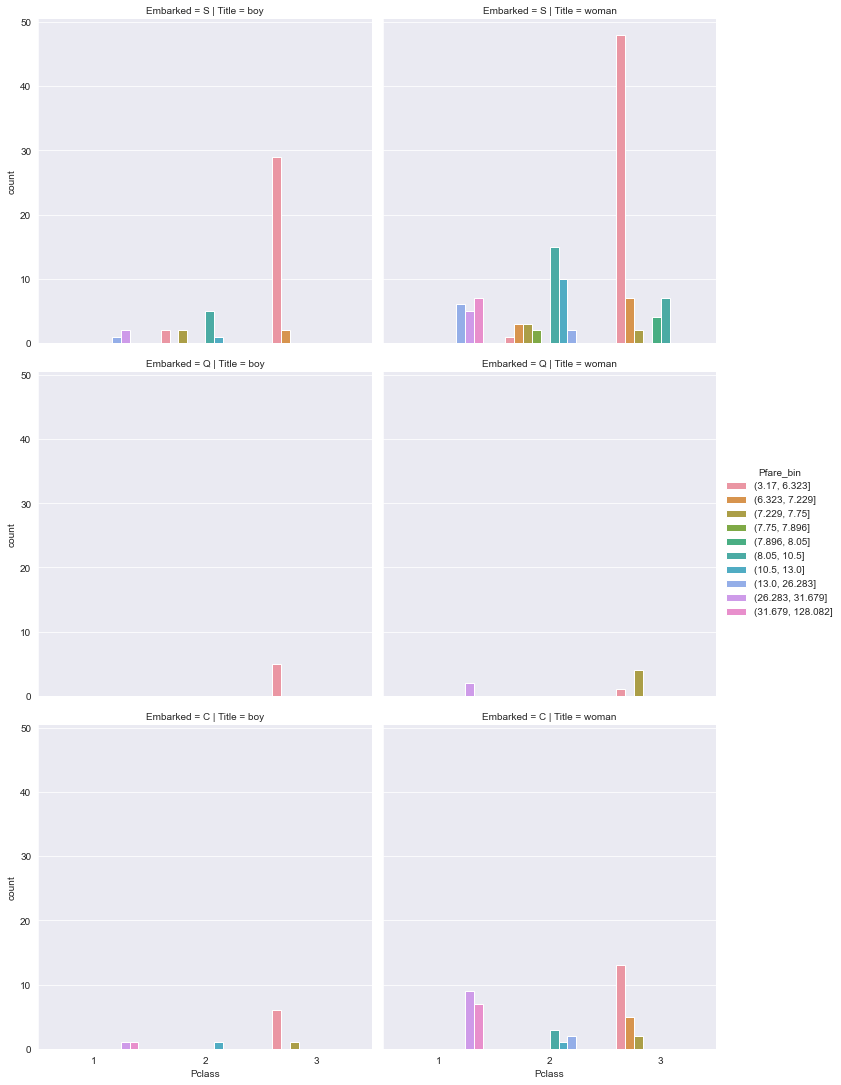

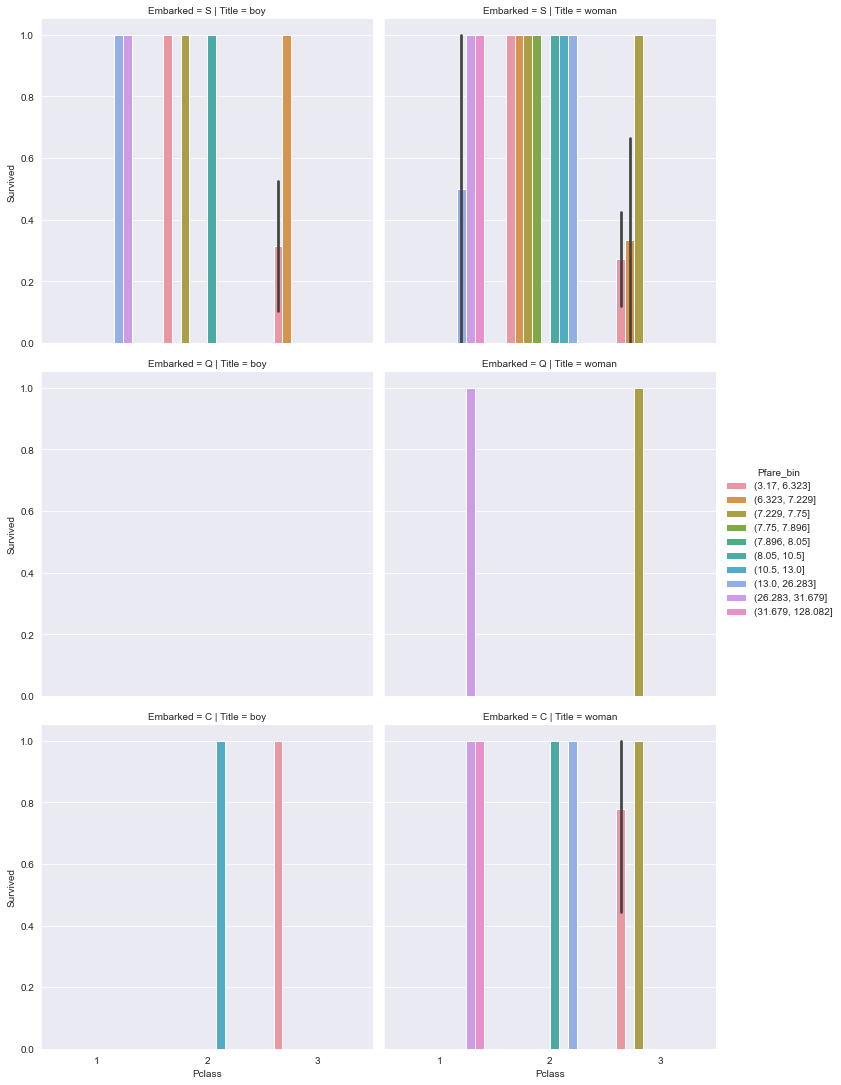

In [45]:
sns.catplot(x="Pclass", y=None, hue="Pfare_bin", row="Embarked", col="Title", data=df.loc[df.Group_id != "noGroup"], kind="count")
sns.catplot(x="Pclass", y="Survived", hue="Pfare_bin", row="Embarked", col="Title", data=df.loc[df.Group_id != "noGroup"], kind="bar")

* 根据四重交叉特征, 发现:
* Gibson家族大概率应该是同生的.
* Klasen, Peacock, van Billiard家族大概率都是同死的.

In [46]:
df.loc[df.Group_id.isin(groups_test), "WCSurvived"] = 0.0
df.loc[df.Surname == "Gibson", "WCSurvived"] = 1.0
df.loc[df.Group_id.isin(groups_test)].sort_values(by="Surname")

,PassengerId,Survived,Pclass,Name,Ticket,Fare,Embarked,Title,Pfare,Pfare_bin,Surname,Ticket_id,Group_id,WC_count,WCSurvived
1259,1260,NaN,1,"Gibson, Mrs. Leonard (Pauline C Boeson)",112378,59.4000,C,woman,29.700000,"(26.283, 31.679]",Gibson,1-11237-59.4-C,Gibson-1-11237-59.4-C,2.0,1.0
1293,1294,NaN,1,"Gibson, Miss. Dorothy Winifred",112378,59.4000,C,woman,29.700000,"(26.283, 31.679]",Gibson,1-11237-59.4-C,Gibson-1-11237-59.4-C,2.0,1.0
1044,1045,NaN,3,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",350405,12.1833,S,woman,6.091650,"(3.17, 6.323]",Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,0.0
1154,1155,NaN,3,"Klasen, Miss. Gertrud Emilia",350405,12.1833,S,woman,6.091650,"(3.17, 6.323]",Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,0.0
1050,1051,NaN,3,"Peacock, Mrs. Benjamin (Edith Nile)",SOTON/O.Q. 3101315,13.7750,S,woman,4.591667,"(3.17, 6.323]",Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,0.0
1172,1173,NaN,3,"Peacock, Master. Alfred Edward",SOTON/O.Q. 3101315,13.7750,S,boy,4.591667,"(3.17, 6.323]",Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,0.0
1300,1301,NaN,3,"Peacock, Miss. Treasteall",SOTON/O.Q. 3101315,13.7750,S,woman,4.591667,"(3.17, 6.323]",Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,0.0
1083,1084,NaN,3,"van Billiard, Master. Walter John",A/5. 851,14.5000,S,boy,4.833333,"(3.17, 6.323]",van Billiard,3-A/5. 85-14.5-S,van Billiard-3-A/5. 85-14.5-S,2.0,0.0
1235,1236,NaN,3,"van Billiard, Master. James William",A/5. 851,14.5000,S,boy,4.833333,"(3.17, 6.323]",van Billiard,3-A/5. 85-14.5-S,van Billiard-3-A/5. 85-14.5-S,2.0,0.0


### 检查WCG乘客是否都有了组内生存率

In [47]:
df.loc[(df.Group_id != "noGroup") & df.WCSurvived.isna()].shape[0]

0

* 是的, WCG乘客都有了组内生存率

## 基于组内生存率, 进行预测
* 如果woman的组内生存率是0%, 那么预测她死亡, 否则, 预测她生存
* 如果乘客是man, 一律预测他死亡.
* 如果boy的组内生存率是100%, 那么预测他生存, 否则, 预测他死亡.

* 背后的逻辑:
* woman的生存率整体上是比较高的, 所以默认预测为生存, 预测她死亡, 需要比较严苛的条件(组内生存率是0%)
* man的生存率整体上是比较低的, 光凭组内生存率, 已经无法预测哪些是幸存者了, 所以, 一律预测为死亡.
* boy的组内生存率如果是100%, 那么预测他生存, 如果是0%, 那么预测他死亡, 这两条没有什么可说的. 除去这两条情况, 测试集总共只剩下4个样本了, 根据分析, 发现这4个样本死亡的概率比较大.

In [48]:
df.loc[n_train : n_all - 1, "Predict"] = 0
df.loc[n_train : n_all - 1, "Predict"][(df.Title == "woman")] = 1
df.loc[n_train : n_all - 1, "Predict"][(df.Title == "woman") & (df["WCSurvived"] == 0)] = 0
df.loc[n_train : n_all - 1, "Predict"][(df.Title == "boy") & (df["WCSurvived"] == 1)] = 1

### 测试集里面, 被预测为生存的boy:

In [49]:
df_boy_test = df[n_train:].loc[(df.Title == "boy")]
df_boy_WCG_test = df[n_train:].loc[(df.Title == "boy") & (df.Group_id != "noGroup")]
df_boy_alive = df[n_train:].loc[(df.Title == "boy") & (df.Predict == 1)]
print(f"被预测为生存的boy({df_boy_alive.shape[0]}个, 测试集里面的WCG boy有{df_boy_WCG_test.shape[0]}个, 测试集里面的boy有{df_boy_test.shape[0]}个):")
df_boy_alive

被预测为生存的boy(8个, 测试集里面的WCG boy有19个, 测试集里面的boy有21个):


,PassengerId,Survived,Pclass,Name,Ticket,Fare,Embarked,Title,Pfare,Pfare_bin,Surname,Ticket_id,Group_id,WC_count,WCSurvived,Predict
955,956,NaN,1,"Ryerson, Master. John Borie",PC 17608,262.3750,C,boy,37.482143,"(31.679, 128.082]",Ryerson,1-PC 1760-262.375-C,Ryerson-1-PC 1760-262.375-C,4.0,1.0,1.0
980,981,NaN,2,"Wells, Master. Ralph Lester",29103,23.0000,S,boy,7.666667,"(7.229, 7.75]",Wells,2-2910-23.0-S,Wells-2-2910-23.0-S,3.0,1.0,1.0
1052,1053,NaN,3,"Touma, Master. Georges Youssef",2650,15.2458,C,boy,5.081933,"(3.17, 6.323]",Touma,3-265-15.2458-C,Touma-3-265-15.2458-C,3.0,1.0,1.0
1085,1086,NaN,2,"Drew, Master. Marshall Brines",28220,32.5000,S,boy,10.833333,"(10.5, 13.0]",Drew,2-2822-32.5-S,Drew-2-2822-32.5-S,2.0,1.0,1.0
1087,1088,NaN,1,"Spedden, Master. Robert Douglas",16966,134.5000,C,boy,26.900000,"(26.283, 31.679]",Spedden,1-1696-134.5-C,Spedden-1-1696-134.5-C,2.0,1.0,1.0
1198,1199,NaN,3,"Aks, Master. Philip Frank",392091,9.3500,S,boy,4.675000,"(3.17, 6.323]",Aks,3-39209-9.35-S,Aks-3-39209-9.35-S,2.0,1.0,1.0
1283,1284,NaN,3,"Abbott, Master. Eugene Joseph",C.A. 2673,20.2500,S,boy,6.750000,"(6.323, 7.229]",Abbott,3-C.A. 267-20.25-S,Abbott-3-C.A. 267-20.25-S,2.0,1.0,1.0
1308,1309,NaN,3,"Peter, Master. Michael J",2668,22.3583,C,boy,7.452767,"(7.229, 7.75]",Peter,3-266-22.3583-C,Peter-3-266-22.3583-C,3.0,1.0,1.0


### 测试集里面, 被预测为死亡的woman:

In [50]:
df_woman_test = df[n_train:].loc[(df.Title == "woman")]
df_woman_WCG_test = df[n_train:].loc[(df.Title == "woman") & (df.Group_id != "noGroup")]
df_woman_dead = df[n_train:].loc[(df.Title == "woman") & (df.Predict == 0)]
print(f"被预测为死亡的woman({df_woman_dead.shape[0]}个, 测试集里面的WCG woman有{df_woman_WCG_test.shape[0]}个, 测试集里面的woman有{df_woman_test.shape[0]}个):")
df_woman_dead

被预测为死亡的woman(15个, 测试集里面的WCG woman有55个, 测试集里面的woman有152个):


,PassengerId,Survived,Pclass,Name,Ticket,Fare,Embarked,Title,Pfare,Pfare_bin,Surname,Ticket_id,Group_id,WC_count,WCSurvived,Predict
909,910,NaN,3,"Ilmakangas, Miss. Ida Livija",STON/O2. 3101270,7.9250,S,woman,7.925000,"(7.896, 8.05]",Ilmakangas,3-STON/O2. 310127-7.925-S,Ilmakangas-3-STON/O2. 310127-7.925-S,2.0,0.0,0.0
924,925,NaN,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",W./C. 6607,23.4500,S,woman,5.862500,"(3.17, 6.323]",Johnston,3-W./C. 660-23.45-S,Johnston-3-W./C. 660-23.45-S,3.0,0.0,0.0
928,929,NaN,3,"Cacic, Miss. Manda",315087,8.6625,S,woman,8.662500,"(8.05, 10.5]",Cacic,3-31508-8.6625-S,Cacic-3-31508-8.6625-S,2.0,0.0,0.0
1023,1024,NaN,3,"Lefebre, Mrs. Frank (Frances)",4133,25.4667,S,woman,5.093340,"(3.17, 6.323]",Lefebre,3-413-25.4667-S,Lefebre-3-413-25.4667-S,5.0,0.0,0.0
1031,1032,NaN,3,"Goodwin, Miss. Jessie Allis",CA 2144,46.9000,S,woman,5.862500,"(3.17, 6.323]",Goodwin,3-CA 214-46.9-S,Goodwin-3-CA 214-46.9-S,6.0,0.0,0.0
1044,1045,NaN,3,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",350405,12.1833,S,woman,6.091650,"(3.17, 6.323]",Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,0.0,0.0
1050,1051,NaN,3,"Peacock, Mrs. Benjamin (Edith Nile)",SOTON/O.Q. 3101315,13.7750,S,woman,4.591667,"(3.17, 6.323]",Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,0.0,0.0
1079,1080,NaN,3,"Sage, Miss. Ada",CA. 2343,69.5500,S,woman,6.322727,"(3.17, 6.323]",Sage,3-CA. 234-69.55-S,Sage-3-CA. 234-69.55-S,7.0,0.0,0.0
1140,1141,NaN,3,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",2660,14.4542,C,woman,7.227100,"(6.323, 7.229]",Khalil,3-266-14.4542-C,Zabour-3-266-14.4542-C,1.0,0.0,0.0
1154,1155,NaN,3,"Klasen, Miss. Gertrud Emilia",350405,12.1833,S,woman,6.091650,"(3.17, 6.323]",Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,0.0,0.0


## 提交WCG模型的预测结果

In [51]:
output = pd.DataFrame(
    {
        "PassengerId": df[n_train:].PassengerId,
        "Survived": df[n_train:].Predict.astype("int"),
    }
)
output.to_csv("WCG_gender.csv", index=False)
print("分数为: 0.81578!")

分数为: 0.81578!


## WCG模型成绩评估
#### 0.81578的成绩意味着有341个样本预测正确
#### "gender model"有320个样本预测正确
#### WCG多增加了21个正确预测模型, 但是相比"gender model"只改变了23个样本(其中8个boy, 15个woman)
#### 这意味着这23个样本里面, 有22个正确预测, 1个错误预测, 因为将原先正确的结果改成了错误的结果, 要倒扣分.
#### 这23个样本里面, 有22个正确, 正确率奇高!

# 对非WCG乘客进行预测

## 任务分析
* 之前分析过: 非WCG乘客个数为1079, 其中: man 782个, woman 295个, boy 2个.
* 非WCG的man生存率为16%.
* 非WCG的woman生存率为81.8%, 死亡率为18.2%.(因为是在"gender model"基础上进行修正, 因此, 对找到死亡的woman更感兴趣)
* 非WCG的boy只有2个, 恰好都在测试集里面, 根据分析, 生存率大概率为0%, "gender model"本来就是预测boy为死亡, 并且样本只有2个, 因此, 对于boy, 不需要再建模了.

* 现在任务很清晰了, 两个任务:
1. 在782个man中寻找出幸存者, 训练集里面生存率只有16%.
2. 在295个woman中寻找出遇难者, 训练集里面死亡率只有18.2%

* 因为占比很小, 这两项任务都是比较难的, 要有心理准备, 其中一个证据:
* 这个比赛提交的大部分solutions里面, man全部被预测为死亡, 没有一个幸存者.

In [52]:
df_noGroup = df[["PassengerId", "Survived", "Title", "Pclass", "Pfare", "Embarked", "Group_id"]]
df_noGroup = df_noGroup.loc[df_noGroup.Group_id == "noGroup"]
del df_noGroup["Group_id"]
print(df_noGroup.shape)

(1079, 6)


In [53]:
df_man = df_noGroup.loc[df_noGroup.Title == "man"].copy()
print(df_man.shape)
df_man.head()

(782, 6)


,PassengerId,Survived,Title,Pclass,Pfare,Embarked
0,1,0.0,man,3,7.25000,S
4,5,0.0,man,3,8.05000,S
5,6,0.0,man,3,8.45830,Q
6,7,0.0,man,1,25.93125,S
12,13,0.0,man,3,8.05000,S


In [54]:
df_woman = df_noGroup.loc[df_noGroup.Title == "woman"].copy()
print(df_woman.shape)
df_woman.head()

(295, 6)


,PassengerId,Survived,Title,Pclass,Pfare,Embarked
1,2,1.0,woman,1,35.64165,C
2,3,1.0,woman,3,7.92500,S
3,4,1.0,woman,1,26.55000,S
9,10,1.0,woman,2,15.03540,C
11,12,1.0,woman,1,26.55000,S


* 因为已经使用Title进行分治了, 就不再使用它了.
* 非WCG乘客不能使用WCG模型用到的特征, 比如组内生存率, 因为非WCG乘客要么是man, 要么是单身woman.
* 对于非WCG乘客, 使用之前分析过的重要特征: Pclass, Pfare, Embarked.

## EDA

### 单个特征

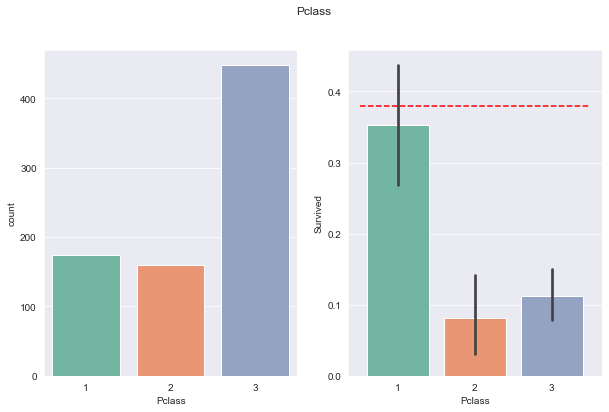

In [55]:
plot_category(df_man, "Pclass")

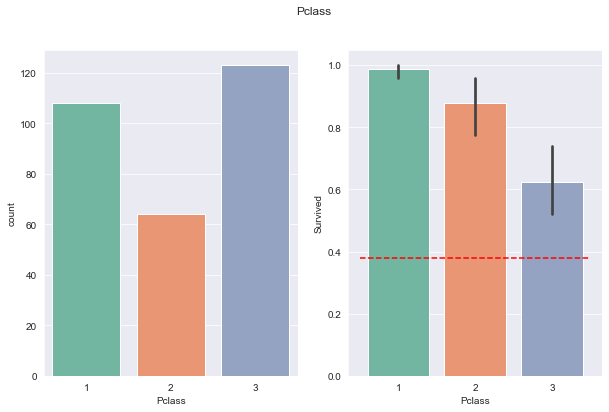

In [56]:
plot_category(df_woman, "Pclass")

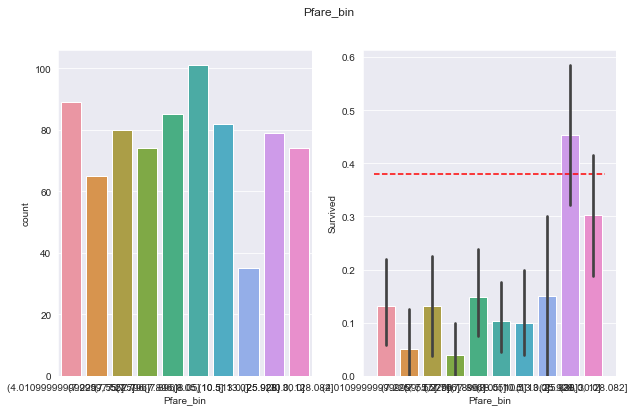

In [57]:
df_man["Pfare_bin"] = pd.qcut(df_man["Pfare"], 10)
plot_category(df_man, "Pfare_bin")

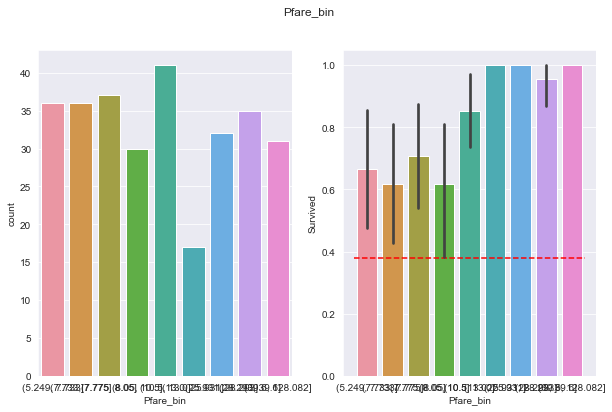

In [58]:
df_woman["Pfare_bin"] = pd.qcut(df_woman["Pfare"], 9)
plot_category(df_woman, "Pfare_bin")

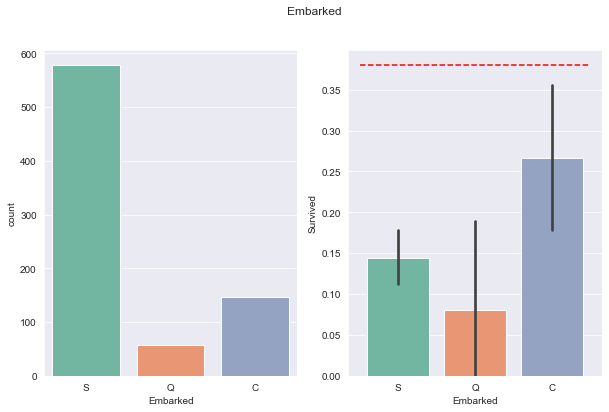

In [59]:
plot_category(df_man, "Embarked")

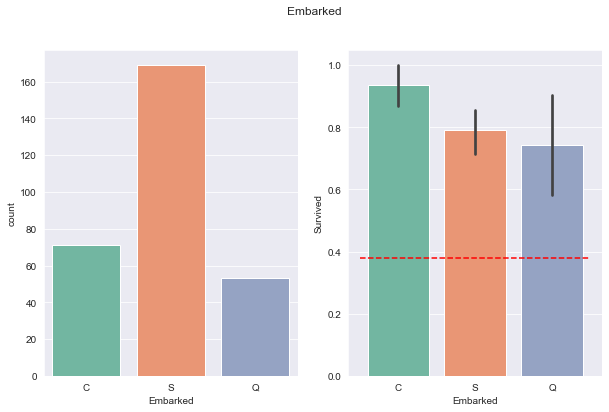

In [60]:
plot_category(df_woman, "Embarked")

* 发现单个特征无法找到man幸存者或者woman遇难者

### 二重交叉特征

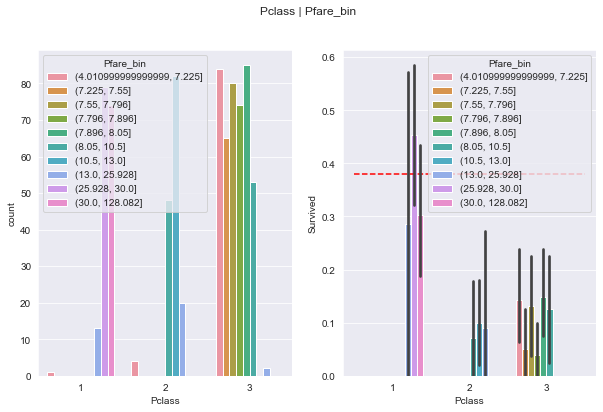

In [61]:
plot_category(df_man, "Pclass", "Pfare_bin")

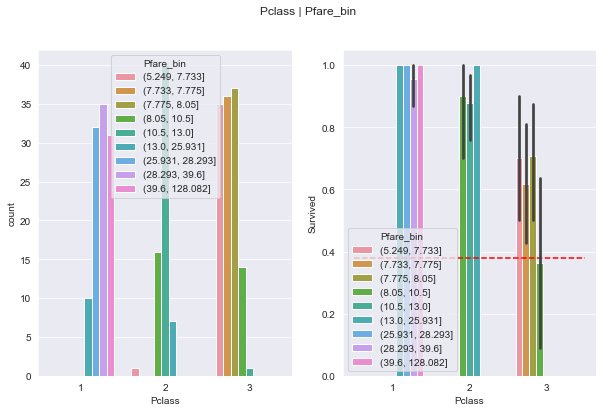

In [62]:
plot_category(df_woman, "Pclass", "Pfare_bin")

* 发现结合Pclass与Pfare, 好像是可以找到woman遇难者的.

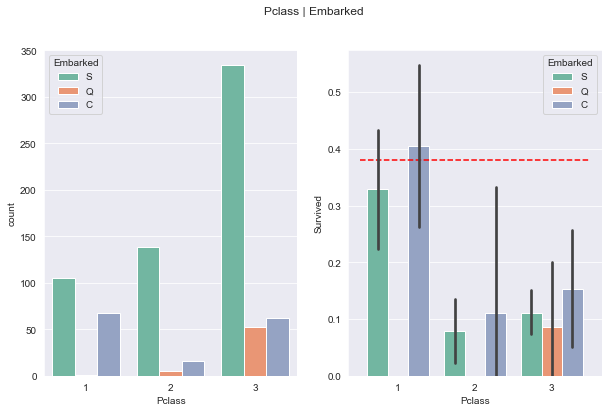

In [63]:
plot_category(df_man, "Pclass", "Embarked")

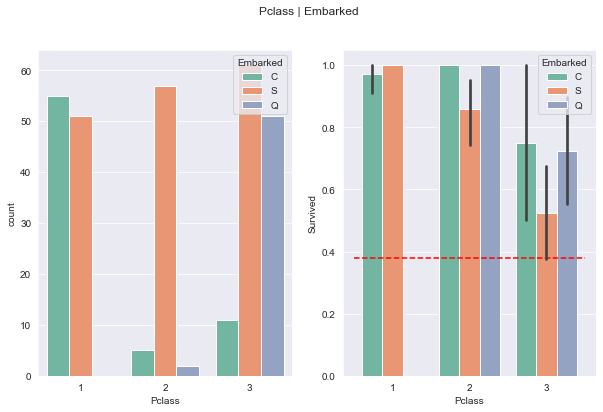

In [64]:
plot_category(df_woman, "Pclass", "Embarked")

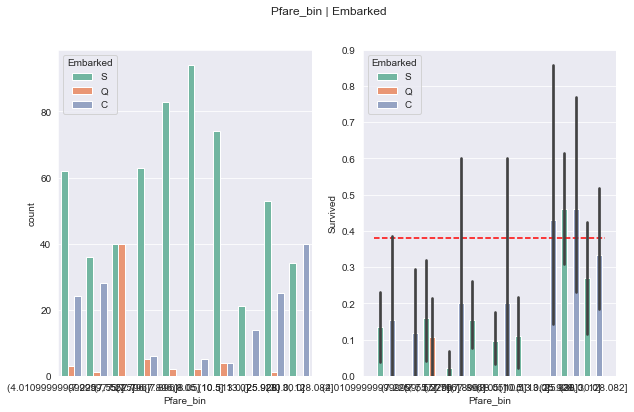

In [65]:
plot_category(df_man, "Pfare_bin", "Embarked")

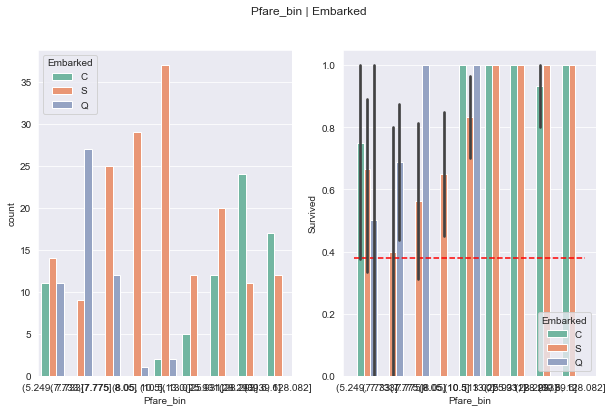

In [66]:
plot_category(df_woman, "Pfare_bin", "Embarked")

* 二重交叉特征小结: 发现结合Pclass与Pfare, 好像是可以找到woman遇难者的.

### 三重交叉特征

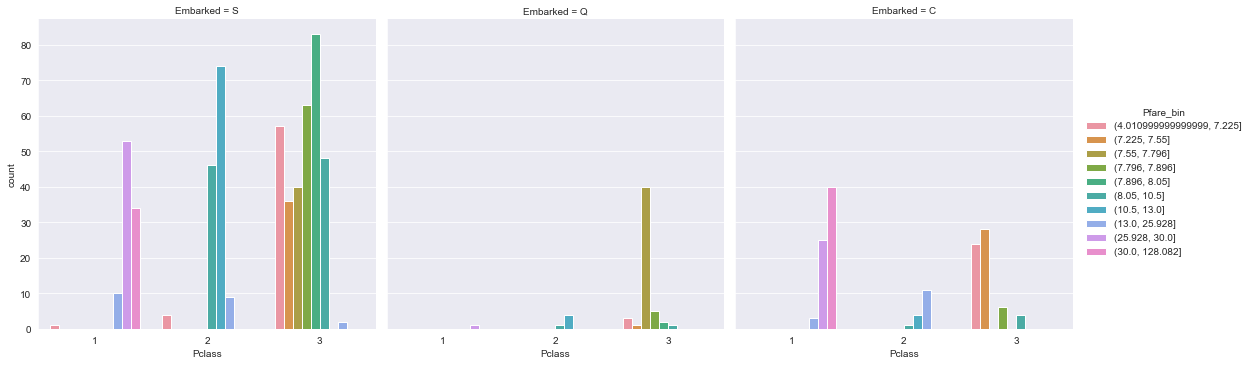

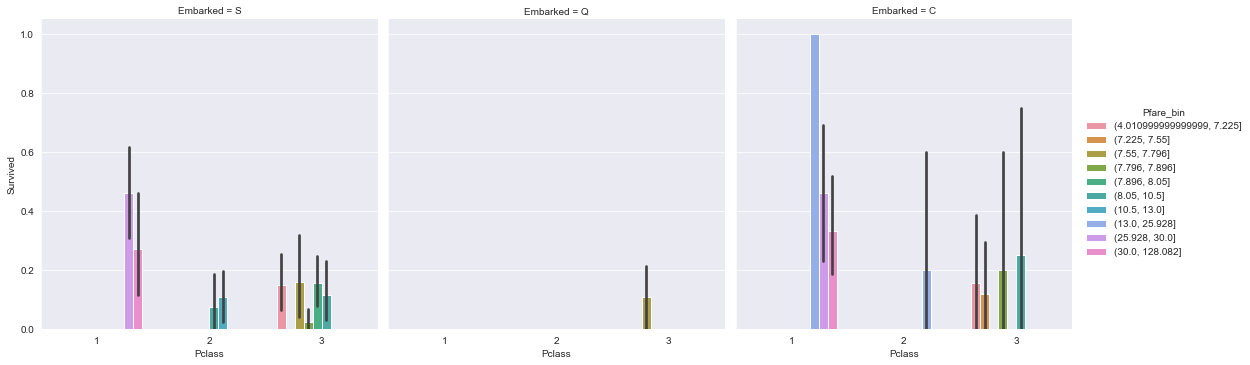

In [67]:
sns.catplot(x="Pclass", y=None, hue="Pfare_bin", col="Embarked", data=df_man, kind="count")
sns.catplot(x="Pclass", y="Survived", hue="Pfare_bin", col="Embarked", data=df_man, kind="bar")

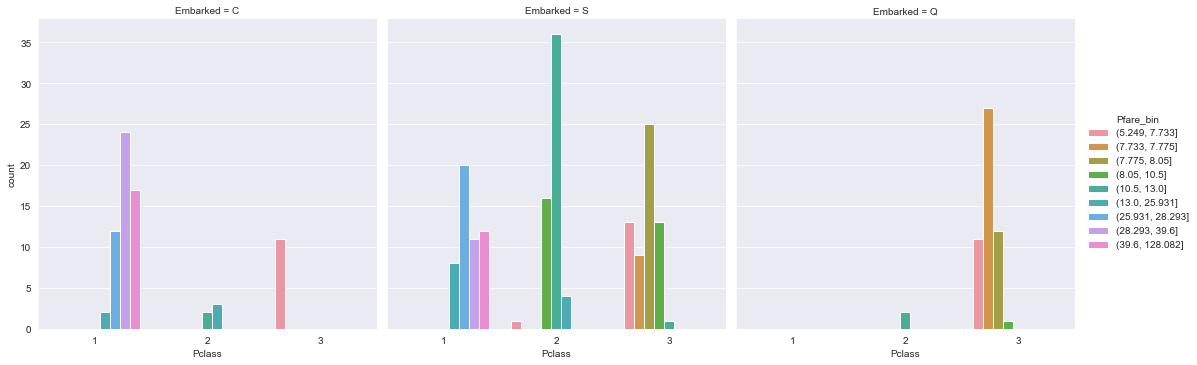

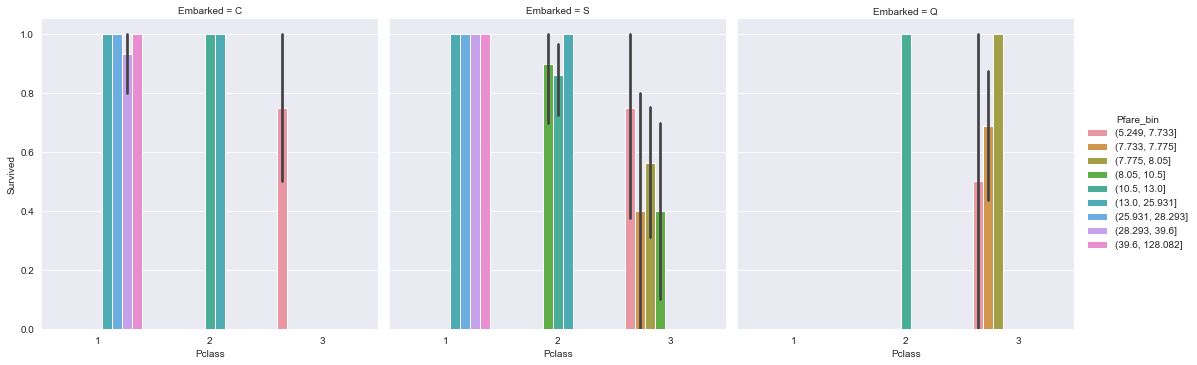

In [68]:
sns.catplot(x="Pclass", y=None, hue="Pfare_bin", col="Embarked", data=df_woman, kind="count")
sns.catplot(x="Pclass", y="Survived", hue="Pfare_bin", col="Embarked", data=df_woman, kind="bar")

* 三重交叉特征小结:
* 对于man, 能否发现幸存者, 但是样本很小, 不知道是否过拟.
* 对于woman, 能否发现遇难者, 样本比man幸存者要多一些, 也要当心过拟.

## EDA小结
* 发现man幸存者难度要比发现woman遇难者要大
* 3个特征结合起来使用, 对于发现这两类群体有帮助.

### 为什么EDA无法直接进行预测?
* EDA只是提供一些思路, 具体进行预测, 需要借助机器学习, 理由:
1. 机器学习将特征结合会更巧妙, 而不像交叉特征那样naive.
2. 机器学习会更科学的验证成绩(比如交叉验证)

## 填充缺失值, 独热编码, 划分数据集

In [69]:
df_man.Pfare.fillna(df_man.Pfare.mean(), inplace=True)
df_woman.Pfare.fillna(df_woman.Pfare.mean(), inplace=True)

df_man.Embarked.fillna("S", inplace=True)
df_woman.Embarked.fillna("S", inplace=True)

df_man.Pfare = (df_man.Pfare - df_man.Pfare.mean()) / df_man.Pfare.std()
df_woman.Pfare = (df_woman.Pfare - df_woman.Pfare.mean()) / df_woman.Pfare.std()


y_man = df_man.Survived
n_man = len(y_man)
n_train_man = y_man.count()
X_man = df_man[["Pclass", "Pfare", "Embarked"]]

y_woman = df_woman.Survived
n_woman = len(y_woman)
n_train_woman = y_woman.count()
X_woman = df_woman[["Pclass", "Pfare", "Embarked"]]

X_man = pd.get_dummies(X_man, columns=["Pclass", "Embarked"])
X_woman = pd.get_dummies(X_woman, columns=["Pclass", "Embarked"])

X_train_man, X_test_man = X_man[:n_train_man].copy(), X_man[n_train_man:].copy()
y_train_man = y_man[:n_train_man].copy()

X_train_woman, X_test_woman = X_woman[:n_train_woman].copy(), X_woman[n_train_woman:].copy()
y_train_woman = y_woman[:n_train_woman].copy()

X_man.head(), X_woman.head()

(       Pfare  Pclass_1  Pclass_2  Pclass_3  Embarked_C  Embarked_Q  Embarked_S
 0  -0.575164         0         0         1           0           0           1
 4  -0.509768         0         0         1           0           0           1
 5  -0.476391         0         0         1           0           1           0
 6   0.951933         1         0         0           0           0           1
 12 -0.509768         0         0         1           0           0           1,
        Pfare  Pclass_1  Pclass_2  Pclass_3  Embarked_C  Embarked_Q  Embarked_S
 1   0.941225         1         0         0           1           0           0
 2  -0.680493         0         0         1           0           0           1
 3   0.409267         1         0         0           0           0           1
 9  -0.264459         0         1         0           1           0           0
 11  0.409267         1         0         0           0           0           1)

## 定义相关函数

In [70]:
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, classification_report

from time import time

random_state = 0


def best_mean_std(cv_results):
    scores = np.array(cv_results["mean_test_score"]) - 0.0 * np.array(
        cv_results["std_test_score"]
    )
    best_idx = np.argmax(scores)
    return best_idx

def score_func_alive(y, y_pred):
    TP = np.sum((y_pred == 1) & (y == 1))
    FP = np.sum((y_pred == 1) & (y == 0))
    return (TP - FP) / len(y)

scoring_alive = make_scorer(score_func_alive)

def score_func_dead(y, y_pred):
    TN = np.sum((y_pred == 0) & (y == 0))
    FN = np.sum((y_pred == 0) & (y == 1))
    return (TN - FN) / len(y)

scoring_dead = make_scorer(score_func_dead)

class Titanic:
    def __init__(self, mdl, scoring, cv):
        self.mdl = mdl
        self.scoring = scoring
        self.cv = cv

    def fit(self, X, y):
        self.mdl.fit(X, y)
        return self

    def predict(self, X):
        y_hat = self.mdl.predict(X)
        return y_hat

    def search(self, X, y, search):
        t0 = time()
        search.fit(X, y)
        t1 = time()
        print(f"Searching elapses {t1 - t0} seconds.")

        best_idx = best_mean_std(search.cv_results_)
        best_params = dict(search.cv_results_["params"][best_idx])
        print(best_params)
        self.mdl.set_params(**best_params)
        scores_val = cross_val_score(
            self.mdl, X, y, scoring=self.scoring, cv=self.cv
        )
        mu = np.mean(scores_val)
        sigma = np.std(scores_val)
        bounds_left = mu - 1.96 * sigma
        bounds_right = mu + 1.96 * sigma
        print(
            f"val score: {mu:.6f} +- {1.96 * sigma:.6f} = "
            f"({bounds_left:.6f}, {bounds_right:.6f})"
        )

        self.mdl.fit(X, y)
        return best_params

## man的ETC模型

In [71]:
from sklearn.ensemble import ExtraTreesClassifier as ETC

from sklearn.model_selection import GridSearchCV

mdl = ETC(random_state=random_state)
cv = KFold(n_splits=15, shuffle=True, random_state=random_state)
titanic_man = Titanic(mdl, scoring_alive, cv)

search_spaces = dict(
    n_estimators=[500],
)

search = GridSearchCV(
    titanic_man.mdl,
    param_grid=search_spaces,
    cv=titanic_man.cv,
    verbose=0,
    refit=False,
    scoring=titanic_man.scoring,
)

titanic_man.search(X_train_man, y_train_man, search)
y_val_hat_man = cross_val_predict(titanic_man.mdl, X_train_man, y_train_man, cv=titanic_man.cv)
print(f"val score: {score_func_alive(y_train_man, y_val_hat_man)}")

print(confusion_matrix(y_train_man, y_val_hat_man))
print(classification_report(y_train_man, y_val_hat_man, digits=6))

titanic_man.fit(X_train_man, y_train_man)
y_test_hat_man = titanic_man.predict(X_test_man)

X_test_man.loc[y_test_hat_man == 1]

Searching elapses 7.820746660232544 seconds.
{'n_estimators': 500}
val score: 0.005556 +- 0.089479 = (-0.083923, 0.095034)
val score: 0.00558659217877095
[[431  20]
 [ 63  23]]
              precision    recall  f1-score   support

         0.0   0.872470  0.955654  0.912169       451
         1.0   0.534884  0.267442  0.356589        86

    accuracy                       0.845438       537
   macro avg   0.703677  0.611548  0.634379       537
weighted avg   0.818406  0.845438  0.823194       537



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
919,1.325405,1,0,0,0,0,1
925,1.192570,1,0,0,1,0,0
930,-0.590534,0,0,1,0,0,1
941,1.284533,1,0,0,0,0,1
959,1.164981,1,0,0,1,0,0
985,0.957553,1,0,0,1,0,0
1022,1.161915,1,0,0,1,0,0
1068,1.098224,1,0,0,1,0,0
1096,0.936438,1,0,0,1,0,0
1125,1.745709,1,0,0,1,0,0


## man的LDA模型

In [72]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import GridSearchCV

mdl = LDA(solver="lsqr")
cv = KFold(n_splits=15, shuffle=True, random_state=random_state)
titanic_man = Titanic(mdl, scoring_alive, cv)

search_spaces = dict(
    shrinkage=np.linspace(0.0, 1.0, 10),
)

search = GridSearchCV(
    titanic_man.mdl,
    param_grid=search_spaces,
    cv=titanic_man.cv,
    verbose=0,
    refit=False,
    scoring=titanic_man.scoring,
)

titanic_man.search(X_train_man, y_train_man, search)
y_val_hat_man = cross_val_predict(titanic_man.mdl, X_train_man, y_train_man, cv=titanic_man.cv)
print(f"val score: {score_func_alive(y_train_man, y_val_hat_man)}")

print(confusion_matrix(y_train_man, y_val_hat_man))
print(classification_report(y_train_man, y_val_hat_man, digits=6))

titanic_man.fit(X_train_man, y_train_man)
y_test_hat_man = titanic_man.predict(X_test_man)

X_test_man.loc[y_test_hat_man == 1]

Searching elapses 0.8606438636779785 seconds.
{'shrinkage': 0.0}
val score: -0.018571 +- 0.065311 = (-0.083882, 0.046739)
val score: -0.0186219739292365
[[435  16]
 [ 80   6]]
              precision    recall  f1-score   support

         0.0   0.844660  0.964523  0.900621       451
         1.0   0.272727  0.069767  0.111111        86

    accuracy                       0.821229       537
   macro avg   0.558694  0.517145  0.505866       537
weighted avg   0.753066  0.821229  0.774182       537



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
966,2.289995,1,0,0,1,0,0
972,3.364515,1,0,0,0,0,1
1009,1.907498,1,0,0,1,0,0
1033,1.896160,1,0,0,1,0,0
1057,2.959959,1,0,0,1,0,0
1093,2.551987,1,0,0,1,0,0
1127,1.907837,1,0,0,1,0,0
1143,4.422686,1,0,0,1,0,0
1161,1.907498,1,0,0,1,0,0
1207,2.824628,1,0,0,1,0,0


## man的LinearSVC模型

In [73]:
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

mdl = LinearSVC()
cv = KFold(n_splits=15, shuffle=True, random_state=random_state)
titanic_man = Titanic(mdl, scoring_alive, cv)

search_spaces = dict(
    C=np.logspace(-5, 3, 10),
)

search = GridSearchCV(
    titanic_man.mdl,
    param_grid=search_spaces,
    cv=titanic_man.cv,
    verbose=0,
    refit=False,
    scoring=titanic_man.scoring,
)

titanic_man.search(X_train_man, y_train_man, search)
y_val_hat_man = cross_val_predict(titanic_man.mdl, X_train_man, y_train_man, cv=titanic_man.cv)
print(f"val score: {score_func_alive(y_train_man, y_val_hat_man)}")

print(confusion_matrix(y_train_man, y_val_hat_man))
print(classification_report(y_train_man, y_val_hat_man, digits=6))

titanic_man.fit(X_train_man, y_train_man)
y_test_hat_man = titanic_man.predict(X_test_man)

X_test_man.loc[y_test_hat_man == 1]

Searching elapses 1.7505974769592285 seconds.
{'C': 1e-05}
val score: 0.001905 +- 0.024297 = (-0.022392, 0.026202)
val score: 0.00186219739292365
[[450   1]
 [ 84   2]]
              precision    recall  f1-score   support

         0.0   0.842697  0.997783  0.913706       451
         1.0   0.666667  0.023256  0.044944        86

    accuracy                       0.841713       537
   macro avg   0.754682  0.510519  0.479325       537
weighted avg   0.814506  0.841713  0.774574       537



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
1143,4.422686,1,0,0,1,0,0


## man的LogisticRegression模型

In [74]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

mdl = LogisticRegression(random_state=random_state)
cv = KFold(n_splits=15, shuffle=True, random_state=random_state)
titanic_man = Titanic(mdl, scoring_alive, cv)

search_spaces = dict(
    C=np.logspace(-3, 3, 10),
    max_iter=[30, 100, 300, 1000],
)

search = GridSearchCV(
    titanic_man.mdl,
    param_grid=search_spaces,
    cv=titanic_man.cv,
    verbose=0,
    refit=False,
    scoring=titanic_man.scoring,
)

titanic_man.search(X_train_man, y_train_man, search)
y_val_hat_man = cross_val_predict(titanic_man.mdl, X_train_man, y_train_man, cv=titanic_man.cv)
print(f"val score: {score_func_alive(y_train_man, y_val_hat_man)}")

print(confusion_matrix(y_train_man, y_val_hat_man))
print(classification_report(y_train_man, y_val_hat_man, digits=6))

titanic_man.fit(X_train_man, y_train_man)
y_test_hat_man = titanic_man.predict(X_test_man)

X_test_man.loc[y_test_hat_man == 1]

Searching elapses 5.528006076812744 seconds.
{'C': 0.021544346900318832, 'max_iter': 30}
val score: 0.001905 +- 0.024297 = (-0.022392, 0.026202)
val score: 0.00186219739292365
[[450   1]
 [ 84   2]]
              precision    recall  f1-score   support

         0.0   0.842697  0.997783  0.913706       451
         1.0   0.666667  0.023256  0.044944        86

    accuracy                       0.841713       537
   macro avg   0.754682  0.510519  0.479325       537
weighted avg   0.814506  0.841713  0.774574       537



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S


## man的NuSVC模型

In [75]:
from sklearn.svm import NuSVC

from sklearn.model_selection import GridSearchCV

mdl = NuSVC()
cv = KFold(n_splits=15, shuffle=True, random_state=random_state)
titanic_man = Titanic(mdl, scoring_alive, cv)

search_spaces = dict(
    nu=np.logspace(-5, -1, 10),
    gamma=np.logspace(-3, 0, 10),
)

search = GridSearchCV(
    titanic_man.mdl,
    param_grid=search_spaces,
    cv=titanic_man.cv,
    verbose=0,
    refit=False,
    scoring=titanic_man.scoring,
)

titanic_man.search(X_train_man, y_train_man, search)
y_val_hat_man = cross_val_predict(titanic_man.mdl, X_train_man, y_train_man, cv=titanic_man.cv)
print(f"val score: {score_func_alive(y_train_man, y_val_hat_man)}")

print(confusion_matrix(y_train_man, y_val_hat_man))
print(classification_report(y_train_man, y_val_hat_man, digits=6))

titanic_man.fit(X_train_man, y_train_man)
y_test_hat_man = titanic_man.predict(X_test_man)

X_test_man.loc[y_test_hat_man == 1]

Searching elapses 8.891923666000366 seconds.
{'gamma': 0.21544346900318823, 'nu': 0.004641588833612777}
val score: -0.157566 +- 0.434795 = (-0.592361, 0.277229)
val score: -0.15828677839851024
[[351 100]
 [ 71  15]]
              precision    recall  f1-score   support

         0.0   0.831754  0.778271  0.804124       451
         1.0   0.130435  0.174419  0.149254        86

    accuracy                       0.681564       537
   macro avg   0.481094  0.476345  0.476689       537
weighted avg   0.719438  0.681564  0.699247       537



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
901,-0.522373,0,0,1,0,0,1
916,-0.575164,0,0,1,0,0,1
930,-0.590534,0,0,1,0,0,1
933,-0.526117,0,0,1,0,0,1
936,-0.519986,0,0,1,0,0,1
947,-0.522373,0,0,1,0,0,1
948,-0.542466,0,0,1,0,0,1
951,-0.522373,0,0,1,0,0,1
953,-0.534291,0,0,1,0,0,1
962,-0.522373,0,0,1,0,0,1


## man的KNN模型

In [76]:
from tempfile import mkdtemp
from shutil import rmtree

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer

from sklearn.model_selection import GridSearchCV

cachedir = mkdtemp()
graph_model = KNeighborsTransformer(n_neighbors=32)
learner = KNeighborsClassifier(n_neighbors=5, metric="precomputed")
mdl = Pipeline(steps=[("graph", graph_model),
                      ("learner", learner)],
               memory=cachedir)


cv = KFold(n_splits=15, shuffle=True, random_state=random_state)
titanic_man = Titanic(mdl, scoring_alive, cv)

search_spaces = dict(
    learner__n_neighbors=np.arange(1, 31),
    learner__weights=["uniform", "distance"],
)

search = GridSearchCV(
    titanic_man.mdl,
    param_grid=search_spaces,
    cv=titanic_man.cv,
    verbose=0,
    refit=False,
    scoring=titanic_man.scoring,
)

titanic_man.search(X_train_man, y_train_man, search)
y_val_hat_man = cross_val_predict(titanic_man.mdl, X_train_man, y_train_man, cv=titanic_man.cv)
print(f"val score: {score_func_alive(y_train_man, y_val_hat_man)}")

print(confusion_matrix(y_train_man, y_val_hat_man))
print(classification_report(y_train_man, y_val_hat_man, digits=6))

titanic_man.fit(X_train_man, y_train_man)
y_test_hat_man = titanic_man.predict(X_test_man)

rmtree(cachedir, ignore_errors=True)

X_test_man.loc[y_test_hat_man == 1]

Searching elapses 9.664851188659668 seconds.
{'learner__n_neighbors': 5, 'learner__weights': 'uniform'}
val score: 0.014921 +- 0.079402 = (-0.064481, 0.094322)
val score: 0.0148975791433892
[[439  12]
 [ 66  20]]
              precision    recall  f1-score   support

         0.0   0.869307  0.973392  0.918410       451
         1.0   0.625000  0.232558  0.338983        86

    accuracy                       0.854749       537
   macro avg   0.747153  0.602975  0.628697       537
weighted avg   0.830181  0.854749  0.825615       537



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
911,1.260009,1,0,0,1,0,0
919,1.325405,1,0,0,0,0,1
930,-0.590534,0,0,1,0,0,1
932,1.002513,1,0,0,0,0,1
936,-0.519986,0,0,1,0,0,1
937,1.260009,1,0,0,1,0,0
941,1.284533,1,0,0,0,0,1
959,1.164981,1,0,0,1,0,0
985,0.957553,1,0,0,1,0,0
988,-0.519986,0,0,1,0,0,1


## man的QDA模型

In [77]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from sklearn.model_selection import GridSearchCV

mdl = QDA()
cv = KFold(n_splits=15, shuffle=True, random_state=random_state)
titanic_man = Titanic(mdl, scoring_alive, cv)

search_spaces = dict(
    reg_param=np.logspace(-6, 0, 10),
)

search = GridSearchCV(
    titanic_man.mdl,
    param_grid=search_spaces,
    cv=titanic_man.cv,
    verbose=0,
    refit=False,
    scoring=titanic_man.scoring,
)

titanic_man.search(X_train_man, y_train_man, search)
y_val_hat_man = cross_val_predict(titanic_man.mdl, X_train_man, y_train_man, cv=titanic_man.cv)
print(f"val score: {score_func_alive(y_train_man, y_val_hat_man)}")

print(confusion_matrix(y_train_man, y_val_hat_man))
print(classification_report(y_train_man, y_val_hat_man, digits=6))

titanic_man.fit(X_train_man, y_train_man)
y_test_hat_man = titanic_man.predict(X_test_man)

X_test_man.loc[y_test_hat_man == 1]

Searching elapses 0.7759695053100586 seconds.
{'reg_param': 1.0}
val score: -0.026032 +- 0.073592 = (-0.099624, 0.047560)
val score: -0.0260707635009311
[[431  20]
 [ 80   6]]
              precision    recall  f1-score   support

         0.0   0.843444  0.955654  0.896050       451
         1.0   0.230769  0.069767  0.107143        86

    accuracy                       0.813780       537
   macro avg   0.537107  0.512711  0.501596       537
weighted avg   0.745325  0.813780  0.769707       537



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
966,2.289995,1,0,0,1,0,0
972,3.364515,1,0,0,0,0,1
1009,1.907498,1,0,0,1,0,0
1033,1.896160,1,0,0,1,0,0
1057,2.959959,1,0,0,1,0,0
1093,2.551987,1,0,0,1,0,0
1106,2.306344,1,0,0,0,0,1
1108,2.201438,1,0,0,0,0,1
1127,1.907837,1,0,0,1,0,0
1143,4.422686,1,0,0,1,0,0


## man的RF模型

In [78]:
from sklearn.ensemble import RandomForestClassifier as RF


from sklearn.model_selection import GridSearchCV

mdl = RF(random_state=random_state)
cv = KFold(n_splits=15, shuffle=True, random_state=random_state)
titanic_man = Titanic(mdl, scoring_alive, cv)

search_spaces = dict(
    n_estimators=[500],
)

search = GridSearchCV(
    titanic_man.mdl,
    param_grid=search_spaces,
    cv=titanic_man.cv,
    verbose=0,
    refit=False,
    scoring=titanic_man.scoring,
)

titanic_man.search(X_train_man, y_train_man, search)
y_val_hat_man = cross_val_predict(titanic_man.mdl, X_train_man, y_train_man, cv=titanic_man.cv)
print(f"val score: {score_func_alive(y_train_man, y_val_hat_man)}")

print(confusion_matrix(y_train_man, y_val_hat_man))
print(classification_report(y_train_man, y_val_hat_man, digits=6))

titanic_man.fit(X_train_man, y_train_man)
y_test_hat_man = titanic_man.predict(X_test_man)

X_test_man.loc[y_test_hat_man == 1]

Searching elapses 10.358498096466064 seconds.
{'n_estimators': 500}
val score: -0.001852 +- 0.094352 = (-0.096204, 0.092500)
val score: -0.00186219739292365
[[429  22]
 [ 65  21]]
              precision    recall  f1-score   support

         0.0   0.868421  0.951220  0.907937       451
         1.0   0.488372  0.244186  0.325581        86

    accuracy                       0.837989       537
   macro avg   0.678397  0.597703  0.616759       537
weighted avg   0.807557  0.837989  0.814673       537



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
919,1.325405,1,0,0,0,0,1
925,1.192570,1,0,0,1,0,0
930,-0.590534,0,0,1,0,0,1
941,1.284533,1,0,0,0,0,1
959,1.164981,1,0,0,1,0,0
985,0.957553,1,0,0,1,0,0
1022,1.161915,1,0,0,1,0,0
1068,1.098224,1,0,0,1,0,0
1096,0.936438,1,0,0,1,0,0
1125,1.745709,1,0,0,1,0,0


## man的SVC模型

In [79]:
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

mdl = SVC()
cv = KFold(n_splits=15, shuffle=True, random_state=random_state)
titanic_man = Titanic(mdl, scoring_alive, cv)

search_spaces = dict(
    C=np.logspace(-3, 3, 10),
    gamma=np.logspace(-3, 3, 10),
)

search = GridSearchCV(
    titanic_man.mdl,
    param_grid=search_spaces,
    cv=titanic_man.cv,
    verbose=0,
    refit=False,
    scoring=titanic_man.scoring,
)

titanic_man.search(X_train_man, y_train_man, search)
y_val_hat_man = cross_val_predict(titanic_man.mdl, X_train_man, y_train_man, cv=titanic_man.cv)
print(f"val score: {score_func_alive(y_train_man, y_val_hat_man)}")

print(confusion_matrix(y_train_man, y_val_hat_man))
print(classification_report(y_train_man, y_val_hat_man, digits=6))

titanic_man.fit(X_train_man, y_train_man)
y_test_hat_man = titanic_man.predict(X_test_man)

X_test_man.loc[y_test_hat_man == 1]

Searching elapses 27.967870950698853 seconds.
{'C': 2.154434690031882, 'gamma': 46.41588833612773}
val score: 0.009418 +- 0.052216 = (-0.042798, 0.061634)
val score: 0.00931098696461825
[[446   5]
 [ 76  10]]
              precision    recall  f1-score   support

         0.0   0.854406  0.988914  0.916752       451
         1.0   0.666667  0.116279  0.198020        86

    accuracy                       0.849162       537
   macro avg   0.760536  0.552596  0.557386       537
weighted avg   0.824340  0.849162  0.801648       537



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
919,1.325405,1,0,0,0,0,1
941,1.284533,1,0,0,0,0,1
985,0.957553,1,0,0,1,0,0
1093,2.551987,1,0,0,1,0,0
1096,0.936438,1,0,0,1,0,0
1189,2.551578,1,0,0,0,0,1


## man的LGBM模型

In [80]:
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV

mdl = LGBMClassifier()
cv = KFold(n_splits=15, shuffle=True, random_state=random_state)
titanic_man = Titanic(mdl, scoring_alive, cv)

search_spaces = dict(
    n_estimators=np.arange(10, 101, 10),
    num_leaves=np.arange(3, 11),
)

search = GridSearchCV(
    titanic_man.mdl,
    param_grid=search_spaces,
    cv=titanic_man.cv,
    verbose=0,
    refit=False,
    scoring=titanic_man.scoring,
)

titanic_man.search(X_train_man, y_train_man, search)
y_val_hat_man = cross_val_predict(titanic_man.mdl, X_train_man, y_train_man, cv=titanic_man.cv)
print(f"val score: {score_func_alive(y_train_man, y_val_hat_man)}")

print(confusion_matrix(y_train_man, y_val_hat_man))
print(classification_report(y_train_man, y_val_hat_man, digits=6))

titanic_man.fit(X_train_man, y_train_man)
y_test_hat_man = titanic_man.predict(X_test_man)

X_test_man.loc[y_test_hat_man == 1]

Searching elapses 42.341248989105225 seconds.
{'n_estimators': 80, 'num_leaves': 7}
val score: 0.011270 +- 0.101421 = (-0.090151, 0.112691)
val score: 0.0111731843575419
[[436  15]
 [ 65  21]]
              precision    recall  f1-score   support

         0.0   0.870259  0.966741  0.915966       451
         1.0   0.583333  0.244186  0.344262        86

    accuracy                       0.851024       537
   macro avg   0.726796  0.605463  0.630114       537
weighted avg   0.824309  0.851024  0.824409       537



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
919,1.325405,1,0,0,0,0,1
930,-0.590534,0,0,1,0,0,1
941,1.284533,1,0,0,0,0,1
985,0.957553,1,0,0,1,0,0
1096,0.936438,1,0,0,1,0,0
1133,1.031123,1,0,0,1,0,0


## man的表现良好的模型小结:
* KNN: 12:20
* SVC: 5:10
* LGBM: 15:21

## woman的ETC模型

In [81]:
from sklearn.ensemble import ExtraTreesClassifier as ETC

from sklearn.model_selection import GridSearchCV

mdl = ETC(random_state=random_state)
cv = KFold(n_splits=9, shuffle=True, random_state=random_state)
titanic_woman = Titanic(mdl, scoring_dead, cv)

search_spaces = dict(
    n_estimators=[500],
)

search = GridSearchCV(
    titanic_woman.mdl,
    param_grid=search_spaces,
    cv=titanic_woman.cv,
    verbose=0,
    refit=False,
    scoring=titanic_woman.scoring,
)

titanic_woman.search(X_train_woman, y_train_woman, search)
y_val_hat_woman = cross_val_predict(titanic_woman.mdl, X_train_woman, y_train_woman, cv=titanic_woman.cv)
print(f"val score: {score_func_dead(y_train_woman, y_val_hat_woman)}")

print(confusion_matrix(y_train_woman, y_val_hat_woman))
print(classification_report(y_train_woman, y_val_hat_woman, digits=6))

titanic_woman.fit(X_train_woman, y_train_woman)
y_test_hat_woman = titanic_woman.predict(X_test_woman)

X_test_woman.loc[y_test_hat_woman == 0]

Searching elapses 7.036043643951416 seconds.
{'n_estimators': 500}
val score: -0.010101 +- 0.137877 = (-0.147978, 0.127776)
val score: -0.010101010101010102
[[ 11  25]
 [ 13 149]]
              precision    recall  f1-score   support

         0.0   0.458333  0.305556  0.366667        36
         1.0   0.856322  0.919753  0.886905       162

    accuracy                       0.808081       198
   macro avg   0.657328  0.612654  0.626786       198
weighted avg   0.783960  0.808081  0.792316       198



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
897,-0.697801,0,0,1,0,1,0
927,-0.673180,0,0,1,0,0,1
978,-0.673180,0,0,1,0,0,1
989,-0.684636,0,0,1,0,0,1
1004,-0.718040,0,0,1,0,1,0
1013,0.545304,1,0,0,1,0,0
1016,-0.673180,0,0,1,0,0,1
1029,-0.673180,0,0,1,0,0,1
1048,-0.684636,0,0,1,0,0,1
1060,-0.619789,0,0,1,0,0,1


## woman的LDA模型

In [82]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import GridSearchCV

mdl = LDA(solver="lsqr")
cv = KFold(n_splits=9, shuffle=True, random_state=random_state)
titanic_woman = Titanic(mdl, scoring_dead, cv)

search_spaces = dict(
    shrinkage=np.linspace(0.0, 1.0, 10),
)

search = GridSearchCV(
    titanic_woman.mdl,
    param_grid=search_spaces,
    cv=titanic_woman.cv,
    verbose=0,
    refit=False,
    scoring=titanic_woman.scoring,
)

titanic_woman.search(X_train_woman, y_train_woman, search)
y_val_hat_woman = cross_val_predict(titanic_woman.mdl, X_train_woman, y_train_woman, cv=titanic_woman.cv)
print(f"val score: {score_func_dead(y_train_woman, y_val_hat_woman)}")

print(confusion_matrix(y_train_woman, y_val_hat_woman))
print(classification_report(y_train_woman, y_val_hat_woman, digits=6))

titanic_woman.fit(X_train_woman, y_train_woman)
y_test_hat_woman = titanic_woman.predict(X_test_woman)

X_test_woman.loc[y_test_hat_woman == 0]

Searching elapses 0.5131125450134277 seconds.
{'shrinkage': 0.0}
val score: -0.025253 +- 0.111994 = (-0.137247, 0.086742)
val score: -0.025252525252525252
[[ 16  20]
 [ 21 141]]
              precision    recall  f1-score   support

         0.0   0.432432  0.444444  0.438356        36
         1.0   0.875776  0.870370  0.873065       162

    accuracy                       0.792929       198
   macro avg   0.654104  0.657407  0.655711       198
weighted avg   0.795168  0.792929  0.794027       198



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
892,-0.734616,0,0,1,0,0,1
927,-0.673180,0,0,1,0,0,1
963,-0.680493,0,0,1,0,0,1
978,-0.673180,0,0,1,0,0,1
981,-0.737541,0,0,1,0,0,1
989,-0.684636,0,0,1,0,0,1
1016,-0.673180,0,0,1,0,0,1
1029,-0.673180,0,0,1,0,0,1
1048,-0.684636,0,0,1,0,0,1
1060,-0.619789,0,0,1,0,0,1


## woman的LinearSVC模型

In [83]:
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

mdl = LinearSVC()
cv = KFold(n_splits=9, shuffle=True, random_state=random_state)
titanic_woman = Titanic(mdl, scoring_dead, cv)

search_spaces = dict(
    C=np.logspace(-5, 3, 10),
)

search = GridSearchCV(
    titanic_woman.mdl,
    param_grid=search_spaces,
    cv=titanic_woman.cv,
    verbose=0,
    refit=False,
    scoring=titanic_woman.scoring,
)

titanic_woman.search(X_train_woman, y_train_woman, search)
y_val_hat_woman = cross_val_predict(titanic_woman.mdl, X_train_woman, y_train_woman, cv=titanic_woman.cv)
print(f"val score: {score_func_dead(y_train_woman, y_val_hat_woman)}")

print(confusion_matrix(y_train_woman, y_val_hat_woman))
print(classification_report(y_train_woman, y_val_hat_woman, digits=6))

titanic_woman.fit(X_train_woman, y_train_woman)
y_test_hat_woman = titanic_woman.predict(X_test_woman)

X_test_woman.loc[y_test_hat_woman == 0]

Searching elapses 0.5930826663970947 seconds.
{'C': 1e-05}
val score: 0.000000 +- 0.000000 = (0.000000, 0.000000)
val score: 0.0
[[  0  36]
 [  0 162]]
              precision    recall  f1-score   support

         0.0   0.000000  0.000000  0.000000        36
         1.0   0.818182  1.000000  0.900000       162

    accuracy                       0.818182       198
   macro avg   0.409091  0.500000  0.450000       198
weighted avg   0.669421  0.818182  0.736364       198



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S


## woman的LogisticRegression模型

In [84]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

mdl = LogisticRegression(random_state=random_state)

cv = KFold(n_splits=9, shuffle=True, random_state=random_state)
titanic_woman = Titanic(mdl, scoring_dead, cv)

search_spaces = dict(
    C=np.logspace(-3, 3, 10),
    max_iter=[30, 100, 300, 1000],
)

search = GridSearchCV(
    titanic_woman.mdl,
    param_grid=search_spaces,
    cv=titanic_woman.cv,
    verbose=0,
    refit=False,
    scoring=titanic_woman.scoring,
)

titanic_woman.search(X_train_woman, y_train_woman, search)
y_val_hat_woman = cross_val_predict(titanic_woman.mdl, X_train_woman, y_train_woman, cv=titanic_woman.cv)
print(f"val score: {score_func_dead(y_train_woman, y_val_hat_woman)}")

print(confusion_matrix(y_train_woman, y_val_hat_woman))
print(classification_report(y_train_woman, y_val_hat_woman, digits=6))

titanic_woman.fit(X_train_woman, y_train_woman)
y_test_hat_woman = titanic_woman.predict(X_test_woman)

X_test_woman.loc[y_test_hat_woman == 0]

Searching elapses 3.9308242797851562 seconds.
{'C': 0.001, 'max_iter': 30}
val score: 0.000000 +- 0.000000 = (0.000000, 0.000000)
val score: 0.0
[[  0  36]
 [  0 162]]
              precision    recall  f1-score   support

         0.0   0.000000  0.000000  0.000000        36
         1.0   0.818182  1.000000  0.900000       162

    accuracy                       0.818182       198
   macro avg   0.409091  0.500000  0.450000       198
weighted avg   0.669421  0.818182  0.736364       198



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S


## woman的NuSVC模型

In [85]:
from sklearn.svm import NuSVC

from sklearn.model_selection import GridSearchCV

mdl = NuSVC()

cv = KFold(n_splits=9, shuffle=True, random_state=random_state)
titanic_woman = Titanic(mdl, scoring_dead, cv)

search_spaces = dict(
    nu=np.logspace(-5, -1, 10),
    gamma=np.logspace(-3, 0, 10),
)

search = GridSearchCV(
    titanic_woman.mdl,
    param_grid=search_spaces,
    cv=titanic_woman.cv,
    verbose=0,
    refit=False,
    scoring=titanic_woman.scoring,
)

titanic_woman.search(X_train_woman, y_train_woman, search)
y_val_hat_woman = cross_val_predict(titanic_woman.mdl, X_train_woman, y_train_woman, cv=titanic_woman.cv)
print(f"val score: {score_func_dead(y_train_woman, y_val_hat_woman)}")

print(confusion_matrix(y_train_woman, y_val_hat_woman))
print(classification_report(y_train_woman, y_val_hat_woman, digits=6))

titanic_woman.fit(X_train_woman, y_train_woman)
y_test_hat_woman = titanic_woman.predict(X_test_woman)

X_test_woman.loc[y_test_hat_woman == 0]

Searching elapses 4.967132091522217 seconds.
{'gamma': 0.0021544346900318843, 'nu': 0.0005994842503189409}
val score: -0.015152 +- 0.083996 = (-0.099147, 0.068844)
val score: -0.015151515151515152
[[  1  35]
 [  4 158]]
              precision    recall  f1-score   support

         0.0   0.200000  0.027778  0.048780        36
         1.0   0.818653  0.975309  0.890141       162

    accuracy                       0.803030       198
   macro avg   0.509326  0.501543  0.469461       198
weighted avg   0.706171  0.803030  0.737166       198



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S


## woman的KNN模型

In [86]:
from tempfile import mkdtemp
from shutil import rmtree

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer

from sklearn.model_selection import GridSearchCV

cachedir = mkdtemp()
graph_model = KNeighborsTransformer(n_neighbors=32)
learner = KNeighborsClassifier(n_neighbors=5, metric="precomputed")
mdl = Pipeline(steps=[("graph", graph_model),
                      ("learner", learner)],
               memory=cachedir)


cv = KFold(n_splits=9, shuffle=True, random_state=random_state)
titanic_woman = Titanic(mdl, scoring_dead, cv)

search_spaces = dict(
    learner__n_neighbors=np.arange(1, 31),
    learner__weights=["uniform", "distance"],
)

search = GridSearchCV(
    titanic_woman.mdl,
    param_grid=search_spaces,
    cv=titanic_woman.cv,
    verbose=0,
    refit=False,
    scoring=titanic_woman.scoring,
)

titanic_woman.search(X_train_woman, y_train_woman, search)
y_val_hat_woman = cross_val_predict(titanic_woman.mdl, X_train_woman, y_train_woman, cv=titanic_woman.cv)
print(f"val score: {score_func_dead(y_train_woman, y_val_hat_woman)}")

print(confusion_matrix(y_train_woman, y_val_hat_woman))
print(classification_report(y_train_woman, y_val_hat_woman, digits=6))

titanic_woman.fit(X_train_woman, y_train_woman)
y_test_hat_woman = titanic_woman.predict(X_test_woman)


rmtree(cachedir, ignore_errors=True)

X_test_woman.loc[y_test_hat_woman == 0]

Searching elapses 5.646376371383667 seconds.
{'learner__n_neighbors': 9, 'learner__weights': 'uniform'}
val score: 0.015152 +- 0.083996 = (-0.068844, 0.099147)
val score: 0.015151515151515152
[[  9  27]
 [  6 156]]
              precision    recall  f1-score   support

         0.0   0.600000  0.250000  0.352941        36
         1.0   0.852459  0.962963  0.904348       162

    accuracy                       0.833333       198
   macro avg   0.726230  0.606481  0.628645       198
weighted avg   0.806557  0.833333  0.804092       198



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
1060,-0.619789,0,0,1,0,0,1
1088,-0.689270,0,0,1,0,0,1
1105,-0.689270,0,0,1,0,0,1
1250,-0.689270,0,0,1,0,0,1
1267,-0.637342,0,0,1,0,0,1
1303,-0.689270,0,0,1,0,0,1


## woman的QDA模型

In [87]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA


from sklearn.model_selection import GridSearchCV

mdl = QDA()

cv = KFold(n_splits=9, shuffle=True, random_state=random_state)
titanic_woman = Titanic(mdl, scoring_dead, cv)

search_spaces = dict(
    reg_param=np.logspace(-6, 0, 10),
)

search = GridSearchCV(
    titanic_woman.mdl,
    param_grid=search_spaces,
    cv=titanic_woman.cv,
    verbose=0,
    refit=False,
    scoring=titanic_woman.scoring,
)

titanic_woman.search(X_train_woman, y_train_woman, search)
y_val_hat_woman = cross_val_predict(titanic_woman.mdl, X_train_woman, y_train_woman, cv=titanic_woman.cv)
print(f"val score: {score_func_dead(y_train_woman, y_val_hat_woman)}")

print(confusion_matrix(y_train_woman, y_val_hat_woman))
print(classification_report(y_train_woman, y_val_hat_woman, digits=6))

titanic_woman.fit(X_train_woman, y_train_woman)
y_test_hat_woman = titanic_woman.predict(X_test_woman)

X_test_woman.loc[y_test_hat_woman == 0]

Searching elapses 0.5017099380493164 seconds.
{'reg_param': 1.0}
val score: 0.000000 +- 0.000000 = (0.000000, 0.000000)
val score: 0.0
[[  0  36]
 [  0 162]]
              precision    recall  f1-score   support

         0.0   0.000000  0.000000  0.000000        36
         1.0   0.818182  1.000000  0.900000       162

    accuracy                       0.818182       198
   macro avg   0.409091  0.500000  0.450000       198
weighted avg   0.669421  0.818182  0.736364       198



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S


## woman的RF模型

In [88]:
from sklearn.ensemble import RandomForestClassifier as RF


from sklearn.model_selection import GridSearchCV

mdl = RF(random_state=random_state)

cv = KFold(n_splits=9, shuffle=True, random_state=random_state)
titanic_woman = Titanic(mdl, scoring_dead, cv)

search_spaces = dict(
    n_estimators=[500],
)

search = GridSearchCV(
    titanic_woman.mdl,
    param_grid=search_spaces,
    cv=titanic_woman.cv,
    verbose=0,
    refit=False,
    scoring=titanic_woman.scoring,
)

titanic_woman.search(X_train_woman, y_train_woman, search)
y_val_hat_woman = cross_val_predict(titanic_woman.mdl, X_train_woman, y_train_woman, cv=titanic_woman.cv)
print(f"val score: {score_func_dead(y_train_woman, y_val_hat_woman)}")

print(confusion_matrix(y_train_woman, y_val_hat_woman))
print(classification_report(y_train_woman, y_val_hat_woman, digits=6))

titanic_woman.fit(X_train_woman, y_train_woman)
y_test_hat_woman = titanic_woman.predict(X_test_woman)

X_test_woman.loc[y_test_hat_woman == 0]

Searching elapses 5.657643795013428 seconds.
{'n_estimators': 500}
val score: -0.030303 +- 0.125994 = (-0.156297, 0.095691)
val score: -0.030303030303030304
[[  6  30]
 [ 12 150]]
              precision    recall  f1-score   support

         0.0   0.333333  0.166667  0.222222        36
         1.0   0.833333  0.925926  0.877193       162

    accuracy                       0.787879       198
   macro avg   0.583333  0.546296  0.549708       198
weighted avg   0.742424  0.787879  0.758107       198



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
897,-0.697801,0,0,1,0,1,0
927,-0.673180,0,0,1,0,0,1
978,-0.673180,0,0,1,0,0,1
1004,-0.718040,0,0,1,0,1,0
1016,-0.673180,0,0,1,0,0,1
1029,-0.673180,0,0,1,0,0,1
1060,-0.619789,0,0,1,0,0,1
1088,-0.689270,0,0,1,0,0,1
1090,-0.669523,0,0,1,0,0,1
1105,-0.689270,0,0,1,0,0,1


## woman的SVC模型

In [89]:
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

mdl = SVC()

cv = KFold(n_splits=9, shuffle=True, random_state=random_state)
titanic_woman = Titanic(mdl, scoring_dead, cv)

search_spaces = dict(
    C=np.logspace(-3, 3, 10),
    gamma=np.logspace(-3, 3, 10),
)

search = GridSearchCV(
    titanic_woman.mdl,
    param_grid=search_spaces,
    cv=titanic_woman.cv,
    verbose=0,
    refit=False,
    scoring=titanic_woman.scoring,
)

titanic_woman.search(X_train_woman, y_train_woman, search)
y_val_hat_woman = cross_val_predict(titanic_woman.mdl, X_train_woman, y_train_woman, cv=titanic_woman.cv)
print(f"val score: {score_func_dead(y_train_woman, y_val_hat_woman)}")

print(confusion_matrix(y_train_woman, y_val_hat_woman))
print(classification_report(y_train_woman, y_val_hat_woman, digits=6))

titanic_woman.fit(X_train_woman, y_train_woman)
y_test_hat_woman = titanic_woman.predict(X_test_woman)

X_test_woman.loc[y_test_hat_woman == 0]

Searching elapses 5.167536497116089 seconds.
{'C': 46.41588833612773, 'gamma': 2.154434690031882}
val score: 0.020202 +- 0.085154 = (-0.064952, 0.105356)
val score: 0.020202020202020204
[[  7  29]
 [  3 159]]
              precision    recall  f1-score   support

         0.0   0.700000  0.194444  0.304348        36
         1.0   0.845745  0.981481  0.908571       162

    accuracy                       0.838384       198
   macro avg   0.772872  0.587963  0.606460       198
weighted avg   0.819246  0.838384  0.798713       198



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
1060,-0.619789,0,0,1,0,0,1
1267,-0.637342,0,0,1,0,0,1


## woman的LGBM模型

In [90]:
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV

mdl = LGBMClassifier()

cv = KFold(n_splits=9, shuffle=True, random_state=random_state)
titanic_woman = Titanic(mdl, scoring_dead, cv)

search_spaces = dict(
    n_estimators=np.arange(10, 101, 10),
    num_leaves=np.arange(3, 21),
)

search = GridSearchCV(
    titanic_woman.mdl,
    param_grid=search_spaces,
    cv=titanic_woman.cv,
    verbose=0,
    refit=False,
    scoring=titanic_woman.scoring,
)

titanic_woman.search(X_train_woman, y_train_woman, search)
y_val_hat_woman = cross_val_predict(titanic_woman.mdl, X_train_woman, y_train_woman, cv=titanic_woman.cv)
print(f"val score: {score_func_dead(y_train_woman, y_val_hat_woman)}")

print(confusion_matrix(y_train_woman, y_val_hat_woman))
print(classification_report(y_train_woman, y_val_hat_woman, digits=6))

titanic_woman.fit(X_train_woman, y_train_woman)
y_test_hat_woman = titanic_woman.predict(X_test_woman)

X_test_woman.loc[y_test_hat_woman == 0]

Searching elapses 44.42310309410095 seconds.
{'n_estimators': 10, 'num_leaves': 3}
val score: 0.000000 +- 0.000000 = (0.000000, 0.000000)
val score: 0.0
[[  0  36]
 [  0 162]]
              precision    recall  f1-score   support

         0.0   0.000000  0.000000  0.000000        36
         1.0   0.818182  1.000000  0.900000       162

    accuracy                       0.818182       198
   macro avg   0.409091  0.500000  0.450000       198
weighted avg   0.669421  0.818182  0.736364       198



,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S


## woman的表现良好的模型小结:
* KNN: 9:6
* SVC: 7:3

## man的集成模型

In [91]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from lightgbm import LGBMClassifier as LGBM
from sklearn.ensemble import VotingClassifier

mdl1 = KNN(n_neighbors=5, weights="uniform")
mdl2 = SVC(**{'C': 2.154434690031882, 'gamma': 46.41588833612773})
mdl3 = LGBM(**{'n_estimators': 80, 'num_leaves': 7})

mdl = VotingClassifier([("KNN", mdl1),
                        ("SVC", mdl2), 
                        ("LGBM", mdl3)],
                      weights=[1,1,1])

mdl.fit(X_train_man, y_train_man)
y_test_hat_man = mdl.predict(X_test_man)

X_test_man.loc[y_test_hat_man == 1]

,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
919,1.325405,1,0,0,0,0,1
930,-0.590534,0,0,1,0,0,1
941,1.284533,1,0,0,0,0,1
985,0.957553,1,0,0,1,0,0
1096,0.936438,1,0,0,1,0,0


## woman的集成模型

In [92]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

mdl1 = KNN(n_neighbors=9, weights="uniform")
mdl2 = SVC(**{'C': 46.41588833612773, 'gamma': 2.154434690031882})

mdl = VotingClassifier([("KNN", mdl1),
                        ("SVC", mdl2)],
                      weights=[1,1])

mdl.fit(X_train_woman, y_train_woman)
y_test_hat_woman = mdl.predict(X_test_woman)

X_test_woman.loc[y_test_hat_woman == 0]

,Pfare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
1060,-0.619789,0,0,1,0,0,1
1088,-0.689270,0,0,1,0,0,1
1105,-0.689270,0,0,1,0,0,1
1250,-0.689270,0,0,1,0,0,1
1267,-0.637342,0,0,1,0,0,1
1303,-0.689270,0,0,1,0,0,1


### 预测与提交

In [93]:
df.loc[X_test_man.loc[y_test_hat_man == 1].index, "Predict"] = y_test_hat_man[y_test_hat_man == 1]
df.loc[X_test_woman.loc[y_test_hat_woman == 0].index, "Predict"] = y_test_hat_woman[y_test_hat_woman == 0]

output = pd.DataFrame(
    {
        "PassengerId": df[n_train:].PassengerId,
        "Survived": df[n_train:].Predict.astype("int"),
    }
)
output.to_csv("WCG_non-WCG.csv", index=False)

* 准确率为0.81818, 意味着总共有342个样本被正确预测, 相比WCG模型, 就只多了1个样本.
* non-WCG模型只改变了11个样本, 意味着其中有6个改对了, 5个被改错了, 净收益为1个样本.
* non-WCG模型的表现不尽如意, 但还是将non-WCG模型保留下来, 目的是为了方便以后套用机器学习的模板.

# 学到了什么?

这个比赛给我的最大收获是: **特征工程决定成绩的上限!**

以前看到过这句话, 但是我是嗤之以鼻的, 但是这个比赛让我对这句话深以为然.

1. WCG模型没有使用任何机器学习模型, 但是预测效果非常好, 23个样本里面有22个改对了, 1个改错了(相比gender model), 这是因为发现了magic特征: 组内生存率, 好的特征不需要机器学习模型, 也能有非常好的表现.
2. non-WCG模型忙乎了半天, 结果11个样本里面6个改对了, 5个改错了, 净收益为1个样本. 一方面是因为non-WCG乘客非常难以预测, 另一方面是因为目前没有找到好的特征来预测non-WCG乘客, 光靠机器学习模型是无法达到好的效果的.


# notebook的参考
这个notebook是在[Link](https://www.kaggle.com/mviola/titanic-wcg-knns-ensemble-0-82775-top-1)的基础上进行改写的.